I'm constantly looking for new ways to visualize data. In this exercise, I'll be comparing different galaxy morphologies (categorical data) against some other parameters in the ECO data set.

In [1]:
import numpy as np
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import pandas as pd
from scipy.interpolate import griddata

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

%matplotlib inline


VISUAL_MORPHOLOGIES = True

In [2]:
eco_columns = ['RAdeg', 'DEdeg', 'cz', 'rMag', 'logM', 'u-r', 'u-J', 'R50', 'R90', 'M', 'FM', 
               'Grp', 'Grpcz', 'FC', 'logMh', 'Den', 'FA', 'FHI', 'FG', 'CCr', 'CCb']

df = pd.read_csv(os.path.join(root_dir, 'data', 'eco_dr1.txt'),
                 delim_whitespace=True, skiprows=56, index_col=0,
                 names=eco_columns)


if VISUAL_MORPHOLOGIES:
    df = df[df.FM == 2] # morphology by eye?

df.head()

RAdeg   DEdeg      cz   rMag   logM   u-r    u-J   R50   R90  M  \
ECO02120  130.095  23.539  3534.8 -20.82  10.23  1.31   3.31  16.2  34.2  L   
ECO08137  130.106  18.316  4373.9 -17.87   8.95  1.84   3.42   4.1  13.6  E   
ECO10139  130.126  27.631  6151.0 -18.99   9.23  1.18   2.30  13.4  27.7  L   
ECO09648  130.153  41.901  7411.4 -18.11   8.79  1.10  18.20   5.1  11.8  L   
ECO05187  130.161  27.241  5488.7 -19.49   9.91  2.01   3.87   9.8  28.7  L   

         ...    Grp   Grpcz  FC  logMh   Den  FA  FHI  FG   CCr  CCb  
ECO02120 ...   1918  3534.8   1  11.63  0.24   0    1   0  1.07  1.0  
ECO08137 ...   5958  4373.9   1  10.84  0.67   0    1   0  1.15  1.0  
ECO10139 ...   7240  6151.0   1  11.06  0.57   1    2   0  1.10  1.0  
ECO09648 ...   6898  7411.4   1  10.88  0.44   0    1   0  1.16  1.0  
ECO05187 ...   3962  5488.7   1  11.18  0.39   1    1   0  1.04  1.0  

[5 rows x 21 columns]

#### Let's compare morphology, u-J color, and density.

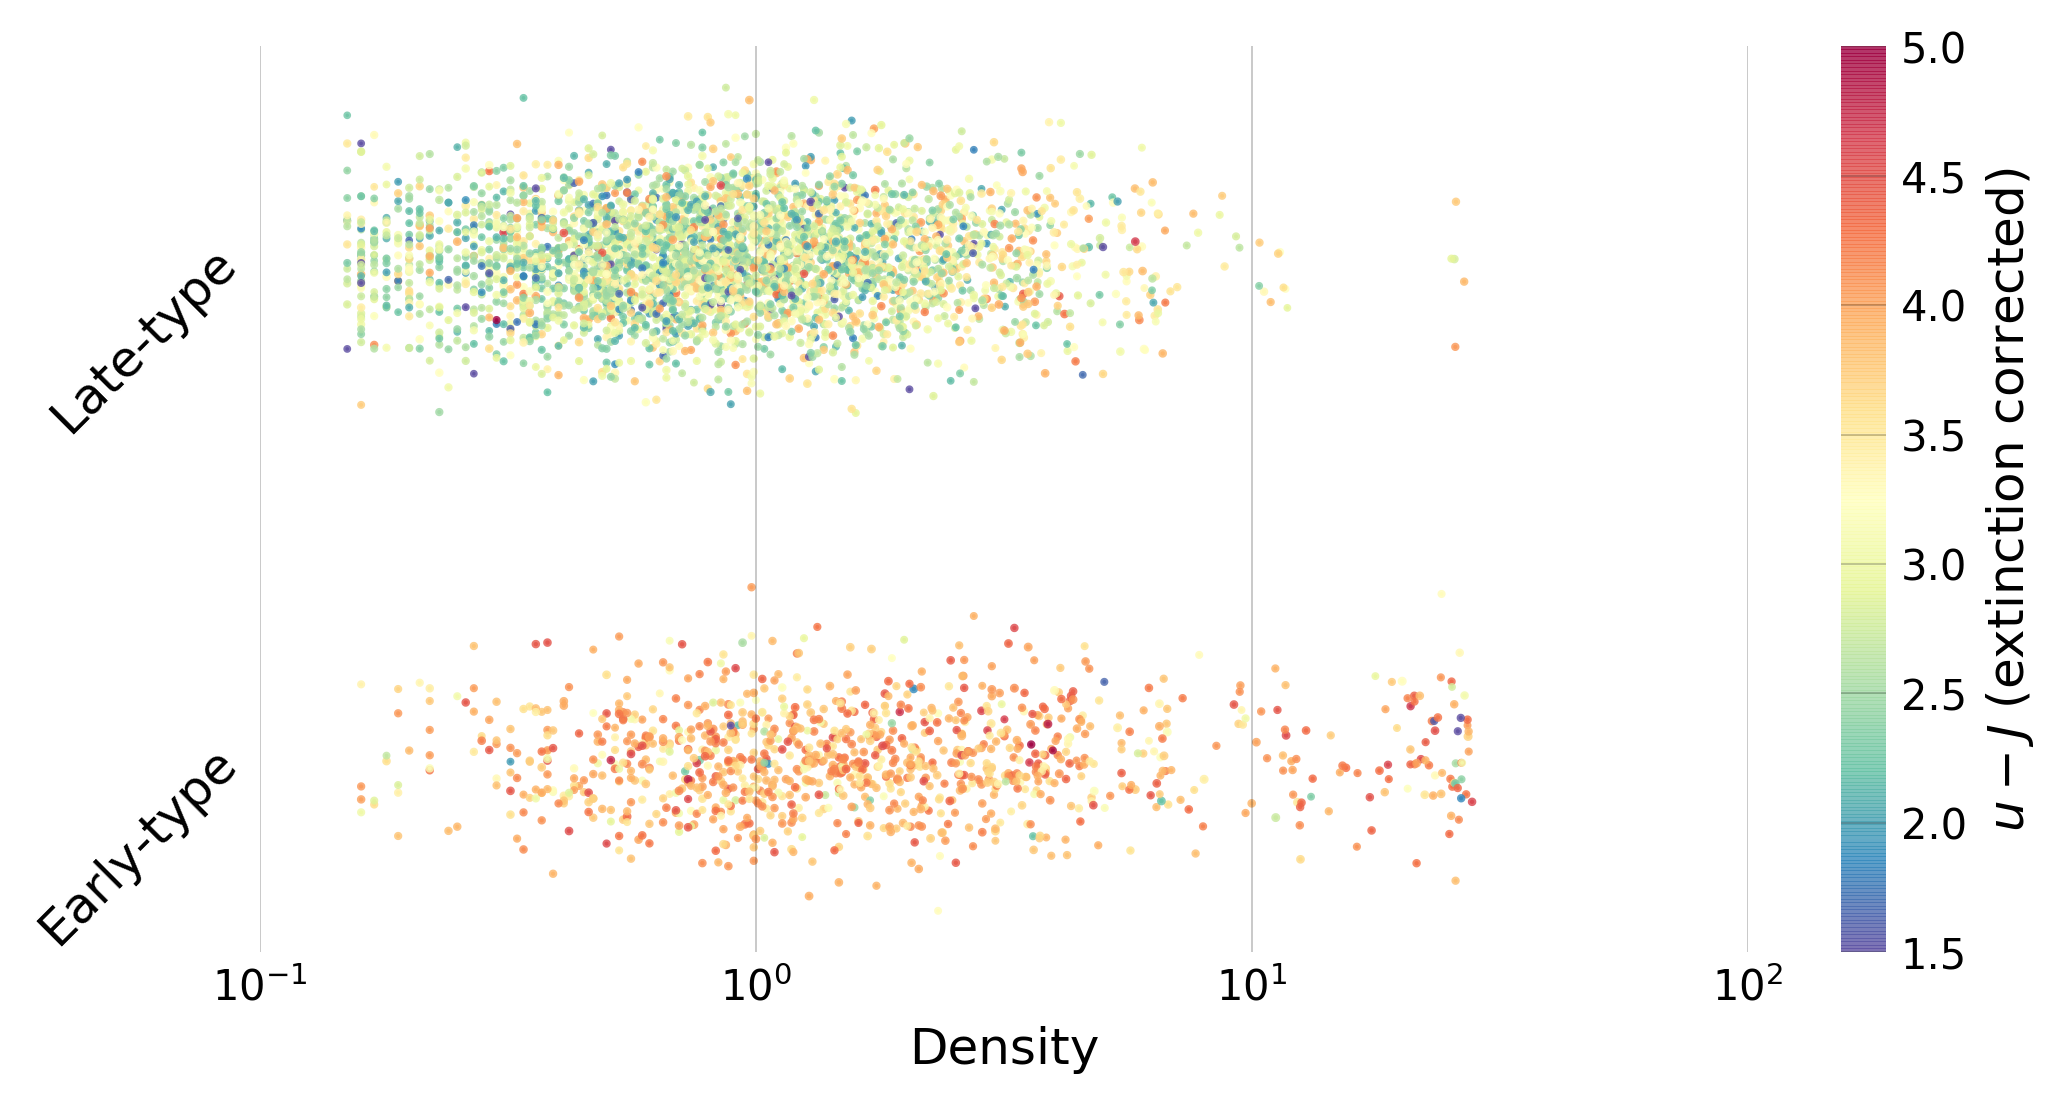

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)

morphologies = df[(df.M != '-') & (10 > df['u-J']) & 
                  (df['u-J'] > -10) & (df['Den'] > 0)].groupby('M')[['u-J', 'Den']]

vmin, vmax = 1.5, 5

for i, [name, group] in enumerate(morphologies):
    morphology = group[['u-J', 'Den', 'logM']]
    
    y = i + np.random.randn(len(morphology)) * 1e-1
    x = morphology['Den']
    s = np.power(morphology['logM'], 2) * 0.01
    c = morphology['u-J'].as_matrix()
    
    im = ax.scatter(x, y, c=c, s=s, cmap=matplotlib.cm.Spectral_r, vmin=vmin, vmax=vmax, alpha=0.8)
    
ax.set_yticks([0, 1])
ax.set_yticklabels(['Early-type', 'Late-type'], rotation=45, fontsize=12)

# remove borders
[spine.set_visible(False) for spine in ax.spines.itervalues()]

ax.set_xlim(0.1, 100)
ax.set_xlabel('Density', fontsize=12)
ax.grid(axis='x', which='major', c='black', lw=0.1)
ax.tick_params(which='both', axis='both', length=0)
ax.set_xscale('log')

cb = fig.colorbar(im, )
cb.outline.set_visible(False)
cb_ax = cb.ax
cb_ax.grid(axis='y', which='major', c='black', lw=0.1)
cb_ax.tick_params(which='both', axis='both', length=0)
cb.set_label('$u-J$ (extinction corrected)', fontsize=12)

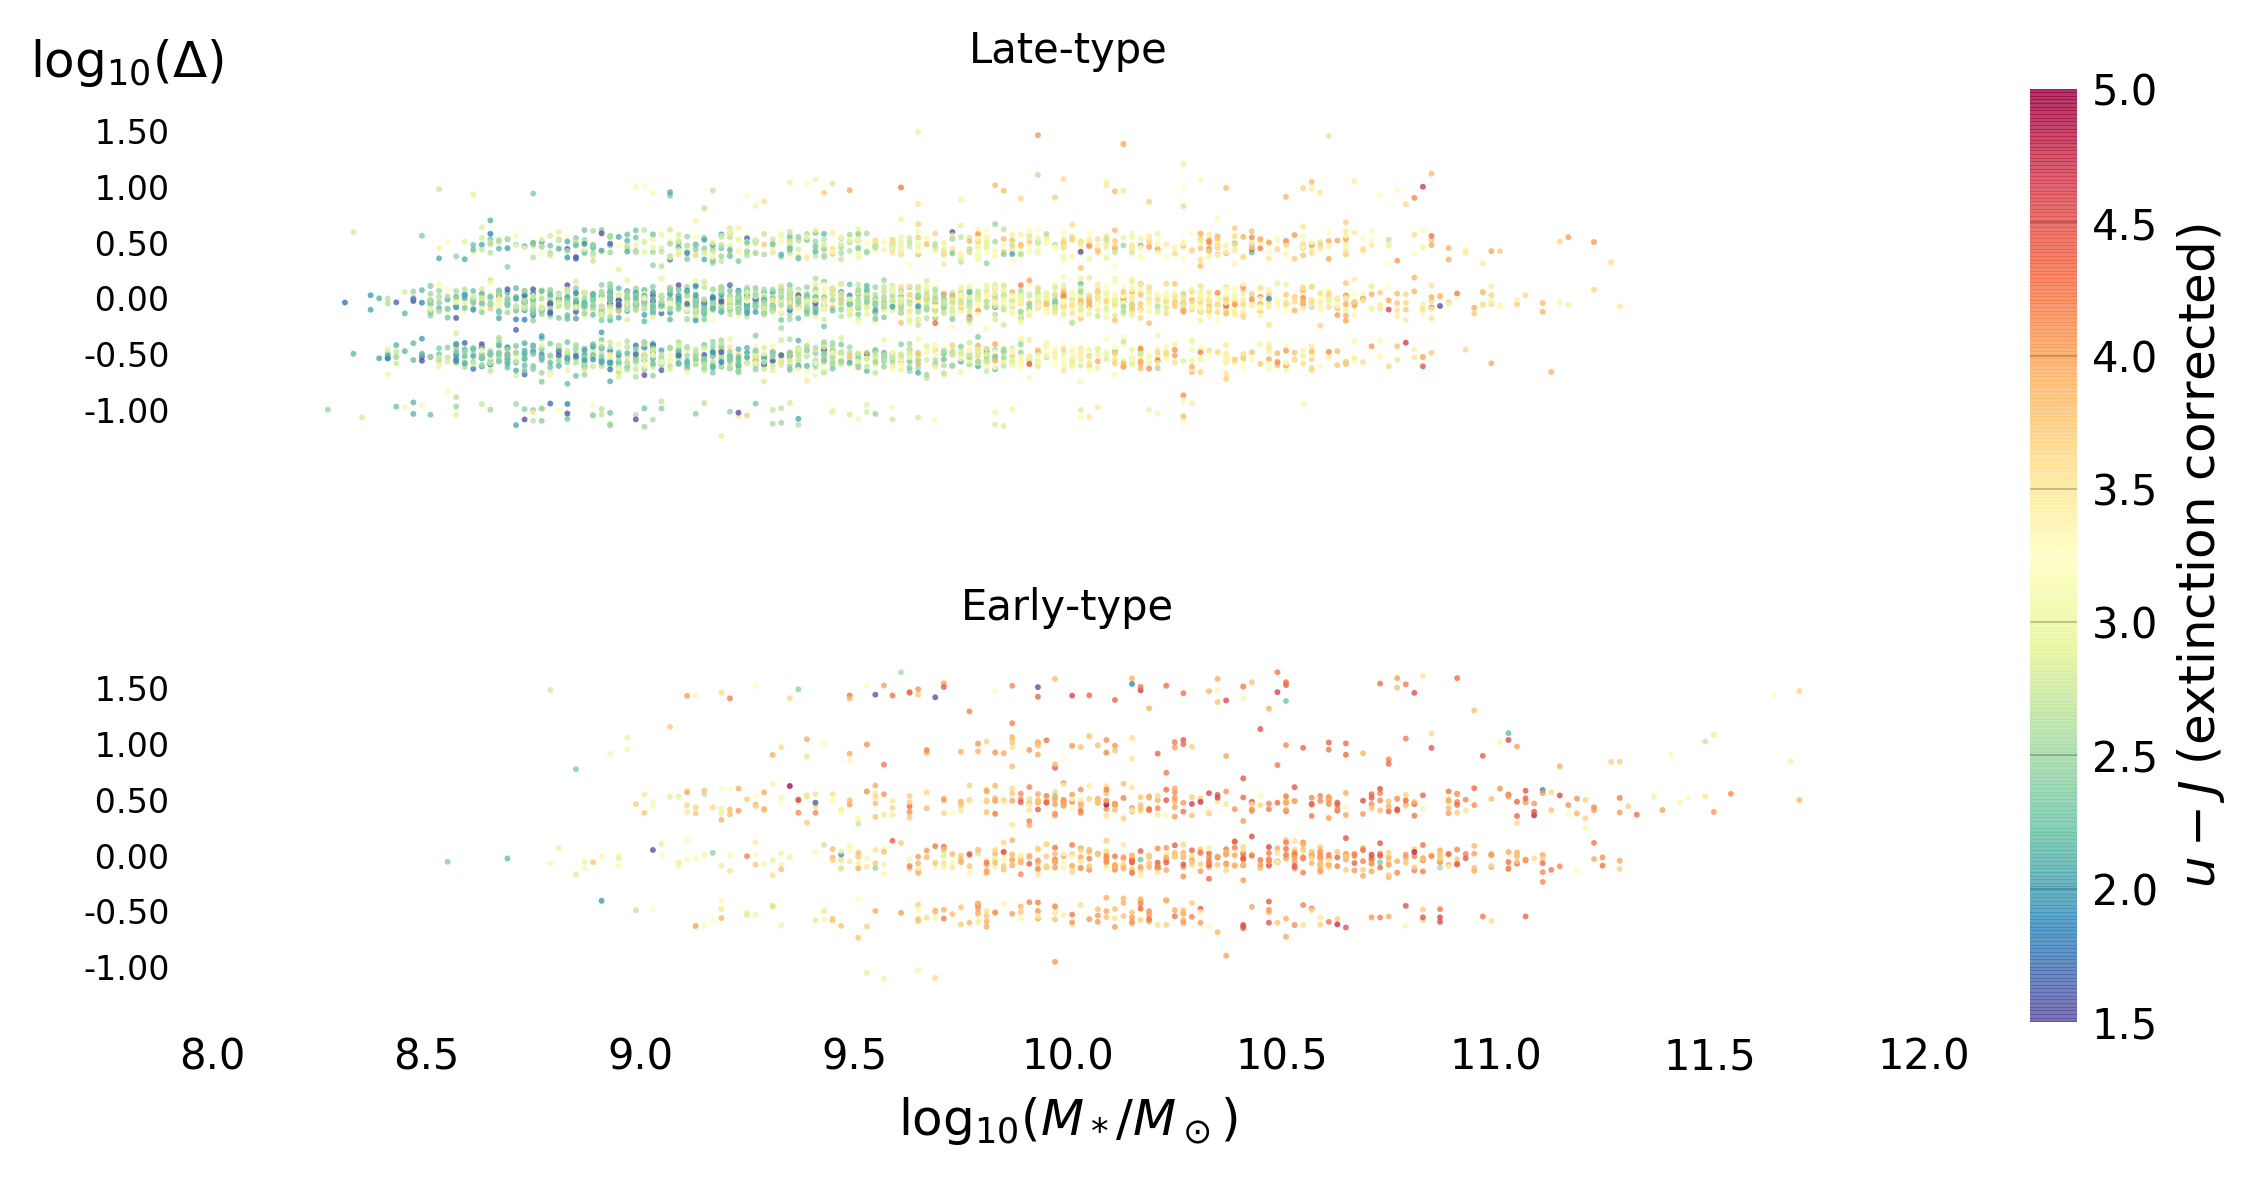

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)

vmin, vmax = 1.5, 5
num_density_bins = 6

for i, [name, group] in enumerate(morphologies):
    morphology = group[['u-J', 'Den', 'logM']]
    
    
    # plot log density 
    log_density = np.log10(morphology['Den'])
    
    for j in xrange(num_density_bins):
        
        log_density_min, log_density_max = -1.25 + j*0.5, -0.75 + j*0.5
        
        morphology_slice = morphology[(log_density > log_density_min) & (log_density < log_density_max)]
        
        # text for log density 
        y0 = i + (j*0.1 - num_density_bins*0.075)
        ax.text(7.8, y0, r'{: .2f}'.format(log_density_min + 0.25), va='center', ha='center', fontsize=8)
        
        # actually plot
        y = y0 + np.random.randn(len(morphology_slice)) * 1.5e-2
        x = morphology_slice['logM']
        c = morphology_slice['u-J'].as_matrix()

        im = ax.scatter(x, y, c=c, s=2.0, cmap=matplotlib.cm.Spectral_r, 
                        vmin=vmin, vmax=vmax, alpha=0.8, edgecolors='none')

        
# label morphologies
ax.text(10, 1.2, 'Late-type', fontsize=10, ha='center', va='center')
ax.text(10, 0.2, 'Early-type', fontsize=10, ha='center', va='center')


ax.set_yticks([])
ax.set_ylabel(r'$\log_{10}(\Delta)$', rotation=0, fontsize=12)
ax.yaxis.set_label_coords(-0.05, 1.)

# remove borders
[spine.set_visible(False) for spine in ax.spines.itervalues()]

ax.set_xlim(8, 12)
ax.set_xlabel('$\log_{10} (M_*/M_\odot)$', fontsize=12)
#ax.grid(axis='x', which='major', c='black', ls='--', lw=0.1)
ax.tick_params(which='both', axis='both', length=0)

cb = fig.colorbar(im, )
cb.outline.set_visible(False)
cb_ax = cb.ax
cb_ax.grid(axis='y', which='major', ls='-', c='black', lw=0.1)
cb_ax.tick_params(which='both', axis='both', length=0)
cb.set_label('$u-J$ (extinction corrected)', fontsize=12)

fig.tight_layout();

I probably should have used two separate subplots...

Let's try the same for halo mass instead of $M_*$.

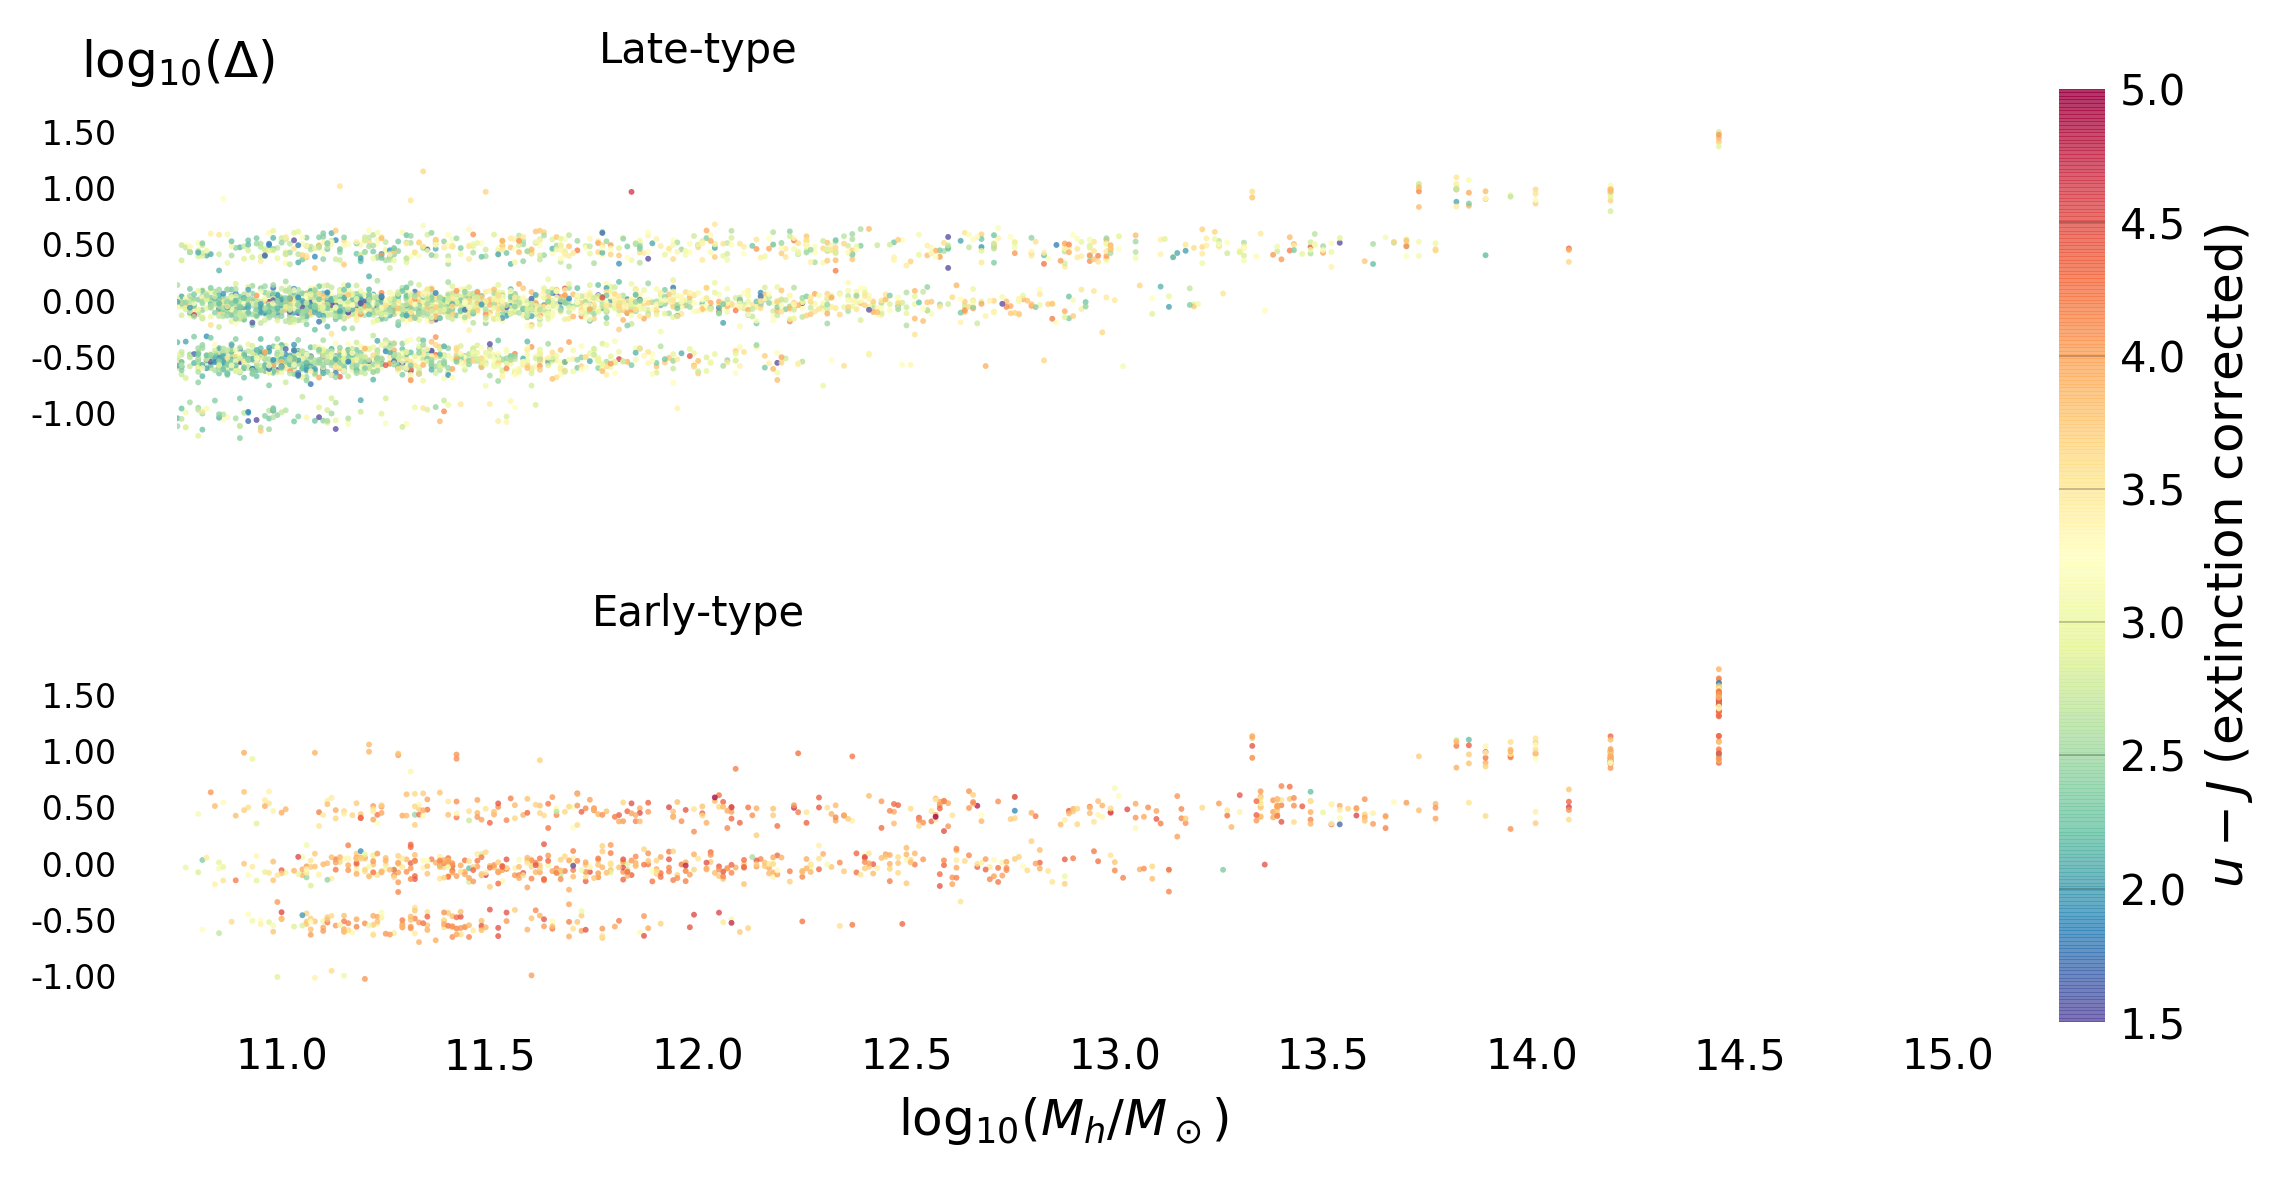

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)

vmin, vmax = 1.5, 5
num_density_bins = 6

for i, [name, group] in enumerate(morphologies):
    morphology = group[['u-J', 'Den', 'logMh']]
    
    # plot log density 
    log_density = np.log10(morphology['Den'])
    
    for j in xrange(num_density_bins):
        
        log_density_min, log_density_max = -1.25 + j*0.5, -0.75 + j*0.5
        
        morphology_slice = morphology[(log_density > log_density_min) & (log_density < log_density_max)]
        
        # text for log density 
        y0 = i + (j*0.1 - num_density_bins*0.075)
        ax.text(10.5, y0, r'{: .2f}'.format(log_density_min + 0.25), va='center', ha='center', fontsize=8)
        
        # actually plot
        y = y0 + np.random.randn(len(morphology_slice)) * 1.5e-2
        x = morphology_slice['logMh']
        c = morphology_slice['u-J'].as_matrix()

        im = ax.scatter(x, y, c=c, s=2.0, cmap=matplotlib.cm.Spectral_r, 
                        vmin=vmin, vmax=vmax, alpha=0.8, edgecolors='none')

        
# label morphologies
ax.text(12, 1.2, 'Late-type', fontsize=10, ha='center', va='center')
ax.text(12, 0.2, 'Early-type', fontsize=10, ha='center', va='center')


ax.set_yticks([])
ax.set_ylabel(r'$\log_{10}(\Delta)$', rotation=0, fontsize=12)
ax.yaxis.set_label_coords(0., 1.)

# remove borders
[spine.set_visible(False) for spine in ax.spines.itervalues()]

ax.set_xlim(10.75, 15)
ax.set_xlabel('$\log_{10} (M_h/M_\odot)$', fontsize=12)
#ax.grid(axis='x', which='major', c='black', ls='--', lw=0.1)
ax.tick_params(which='both', axis='both', length=0)

cb = fig.colorbar(im, )
cb.outline.set_visible(False)
cb_ax = cb.ax
cb_ax.grid(axis='y', which='major', ls='-', c='black', lw=0.1)
cb_ax.tick_params(which='both', axis='both', length=0)
cb.set_label('$u-J$ (extinction corrected)', fontsize=12)

fig.tight_layout();

What if we compare to abundance matching curves, e.g., $f_b$?

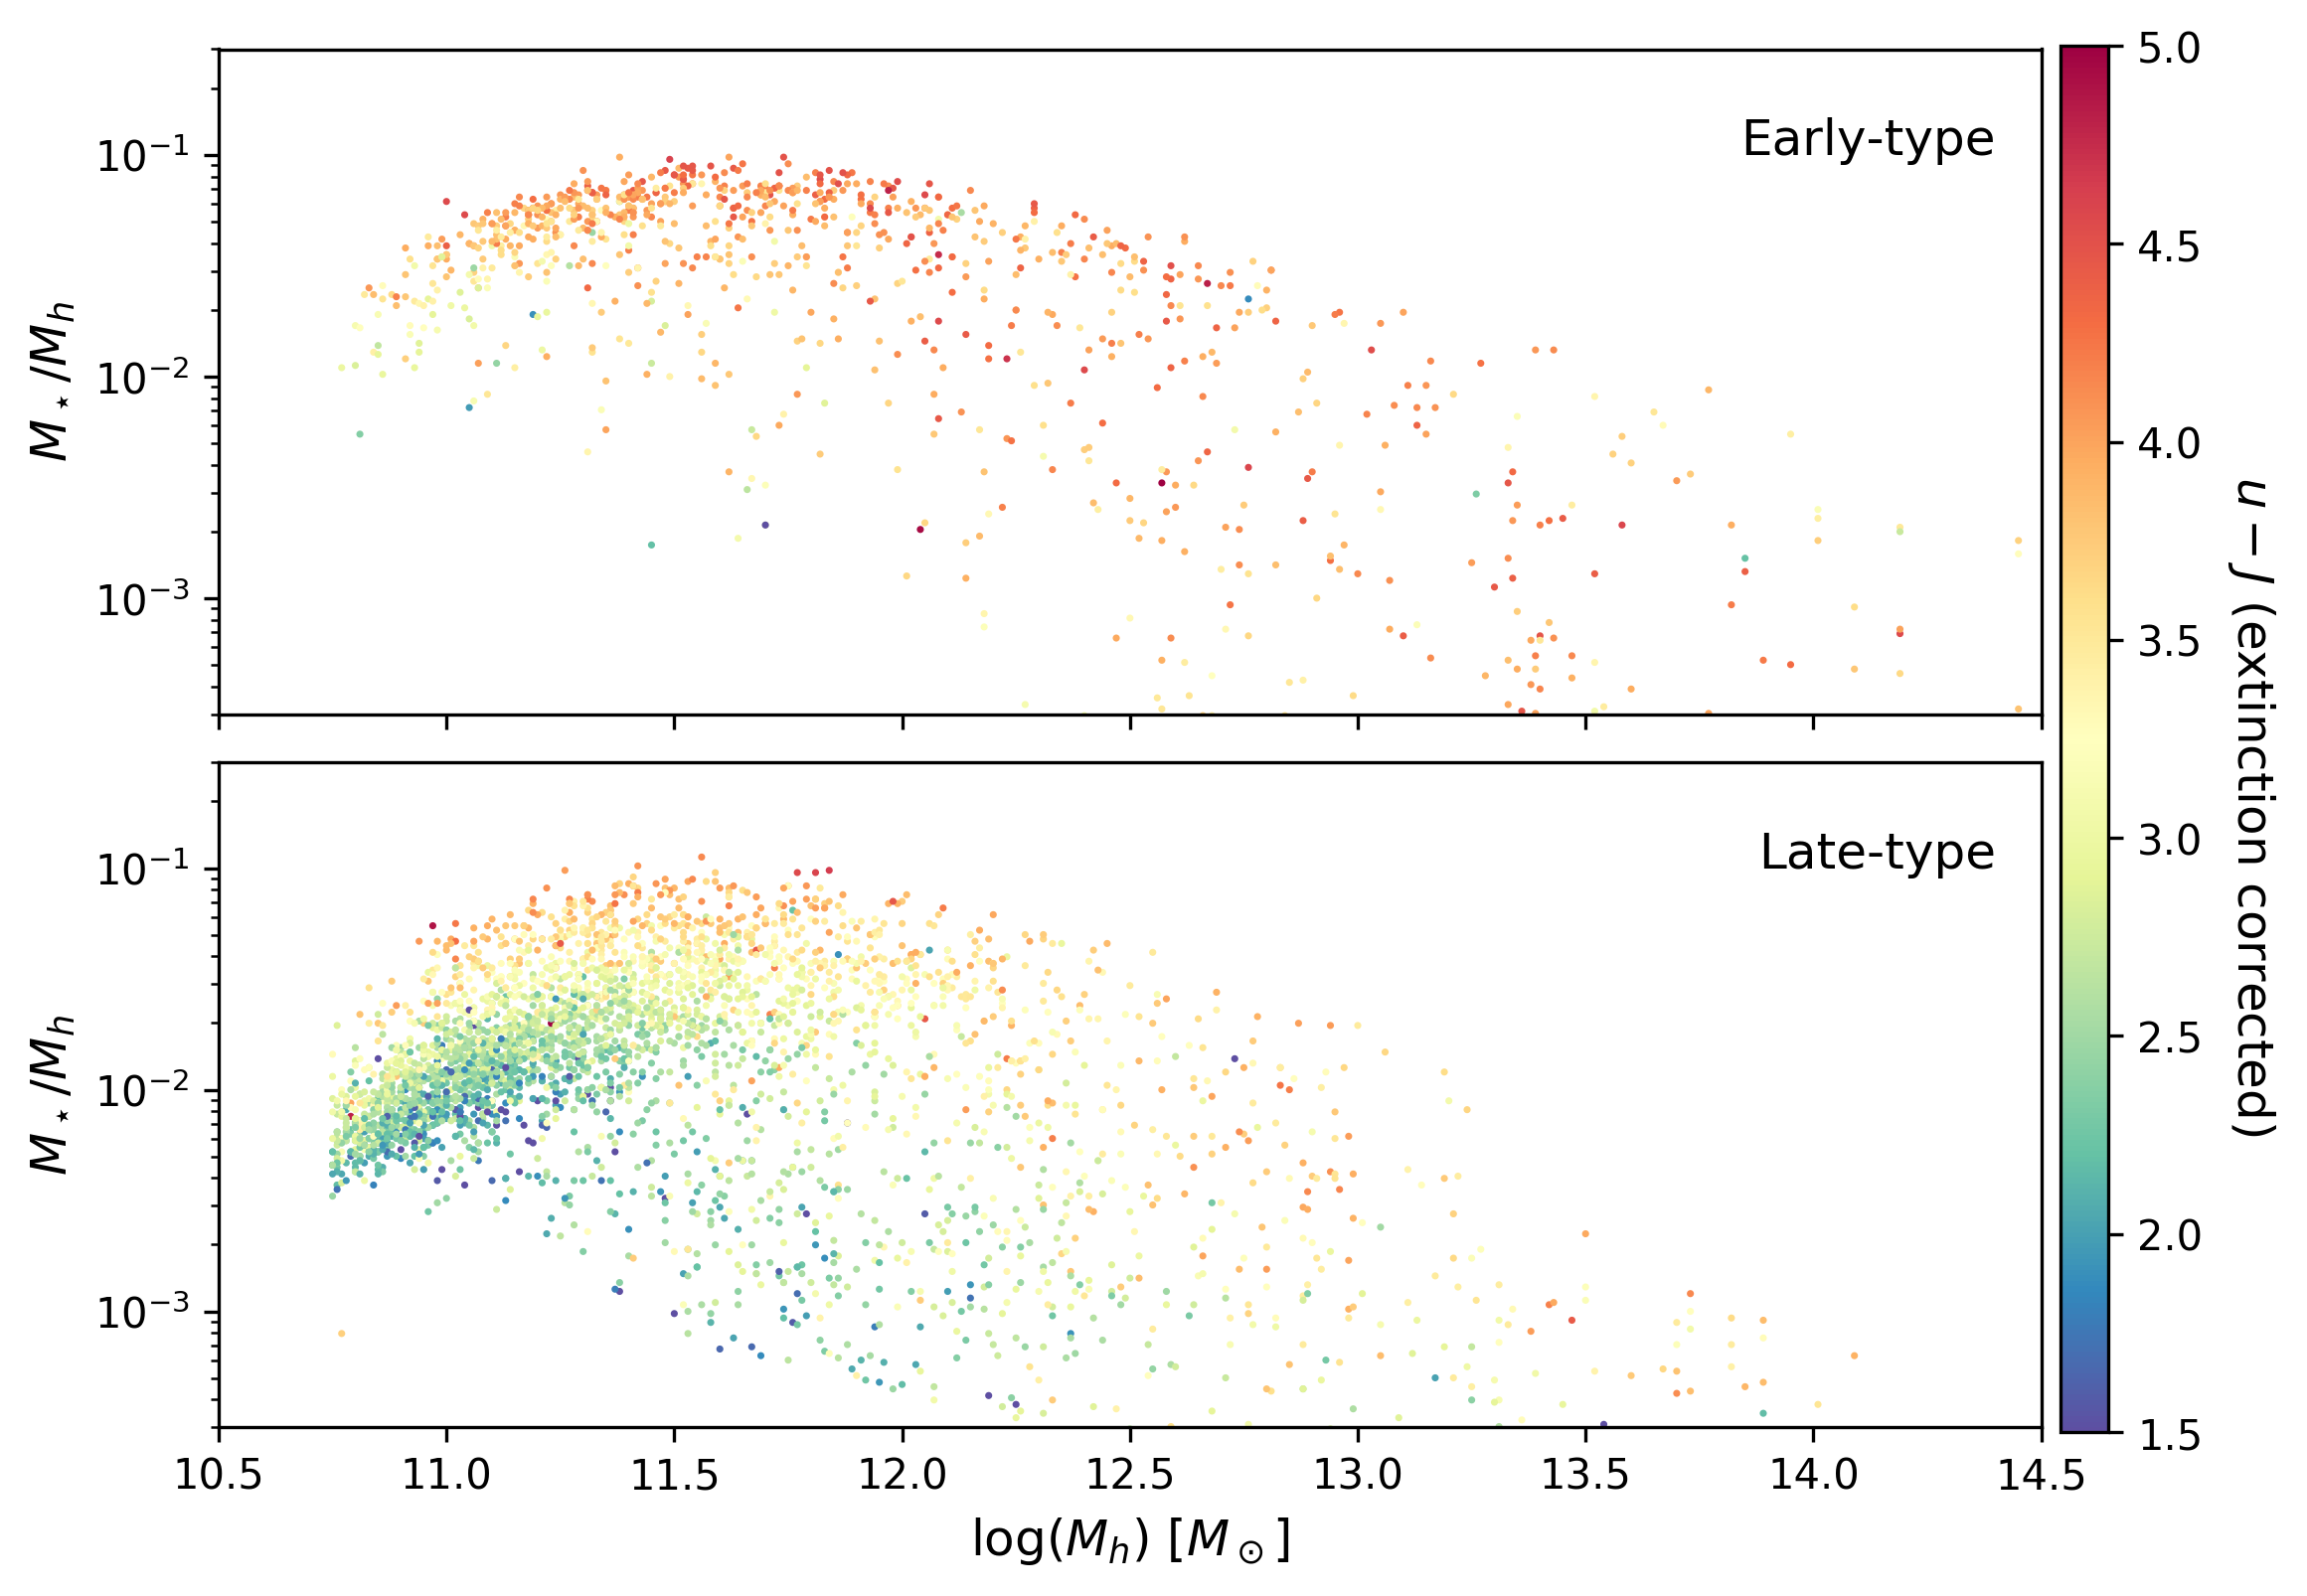

In [6]:
baryons = df[(df.M != '-') & (10 > df['u-J']) 
             & (df['u-J'] > -10) & (df['Den'] > 0)][['u-J', 'logM', 'logMh', 'Den', 'M']]

baryons['stellar_fraction'] = np.power(10, baryons.logM) / np.power(10, baryons.logMh)


# plot
fig, axes = plt.subplots(2, 1, figsize=(8, 6), dpi=300, sharex=True, squeeze=True)

for ax, m in zip(axes.flat, ['E', 'L']):
    morphology = baryons[baryons.M == m]
    
    morph_label = 'Early-type' if m == 'E' else 'Late-type'
    
    im = ax.scatter('logMh', 'stellar_fraction', data=morphology, s=0.5, c='u-J', 
                    cmap=matplotlib.cm.Spectral_r, vmin=1.5, vmax=5.0)
    

    ax.set_ylabel('$M_\star/M_h$', size=12)
    ax.set_yscale('log')
    ax.set_ylim(3e-4, 0.3)
    
    ax.text(14.4, 0.1, morph_label, size=12, ha='right')
    
ax.set_xlim(10.5, 14.5)
ax.set_xlabel('log($M_h$) [$M_\odot$]', size=12)

# note: tight_layout needs to be set *before* the colorbar
fig.tight_layout(h_pad=1., rect=[0.05, 0.05, 0.95, 0.95]);

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.775])
fig.colorbar(im, cax=cbar_ax)

cb_ax.grid(axis='y', which='major', ls='-', c='black', lw=0.1)
cb_ax.tick_params(which='both', axis='both', length=0)
fig.text(1.0, 0.5, '$u-J$ (extinction corrected)', fontsize=12, rotation=270, va='center', ha='center')


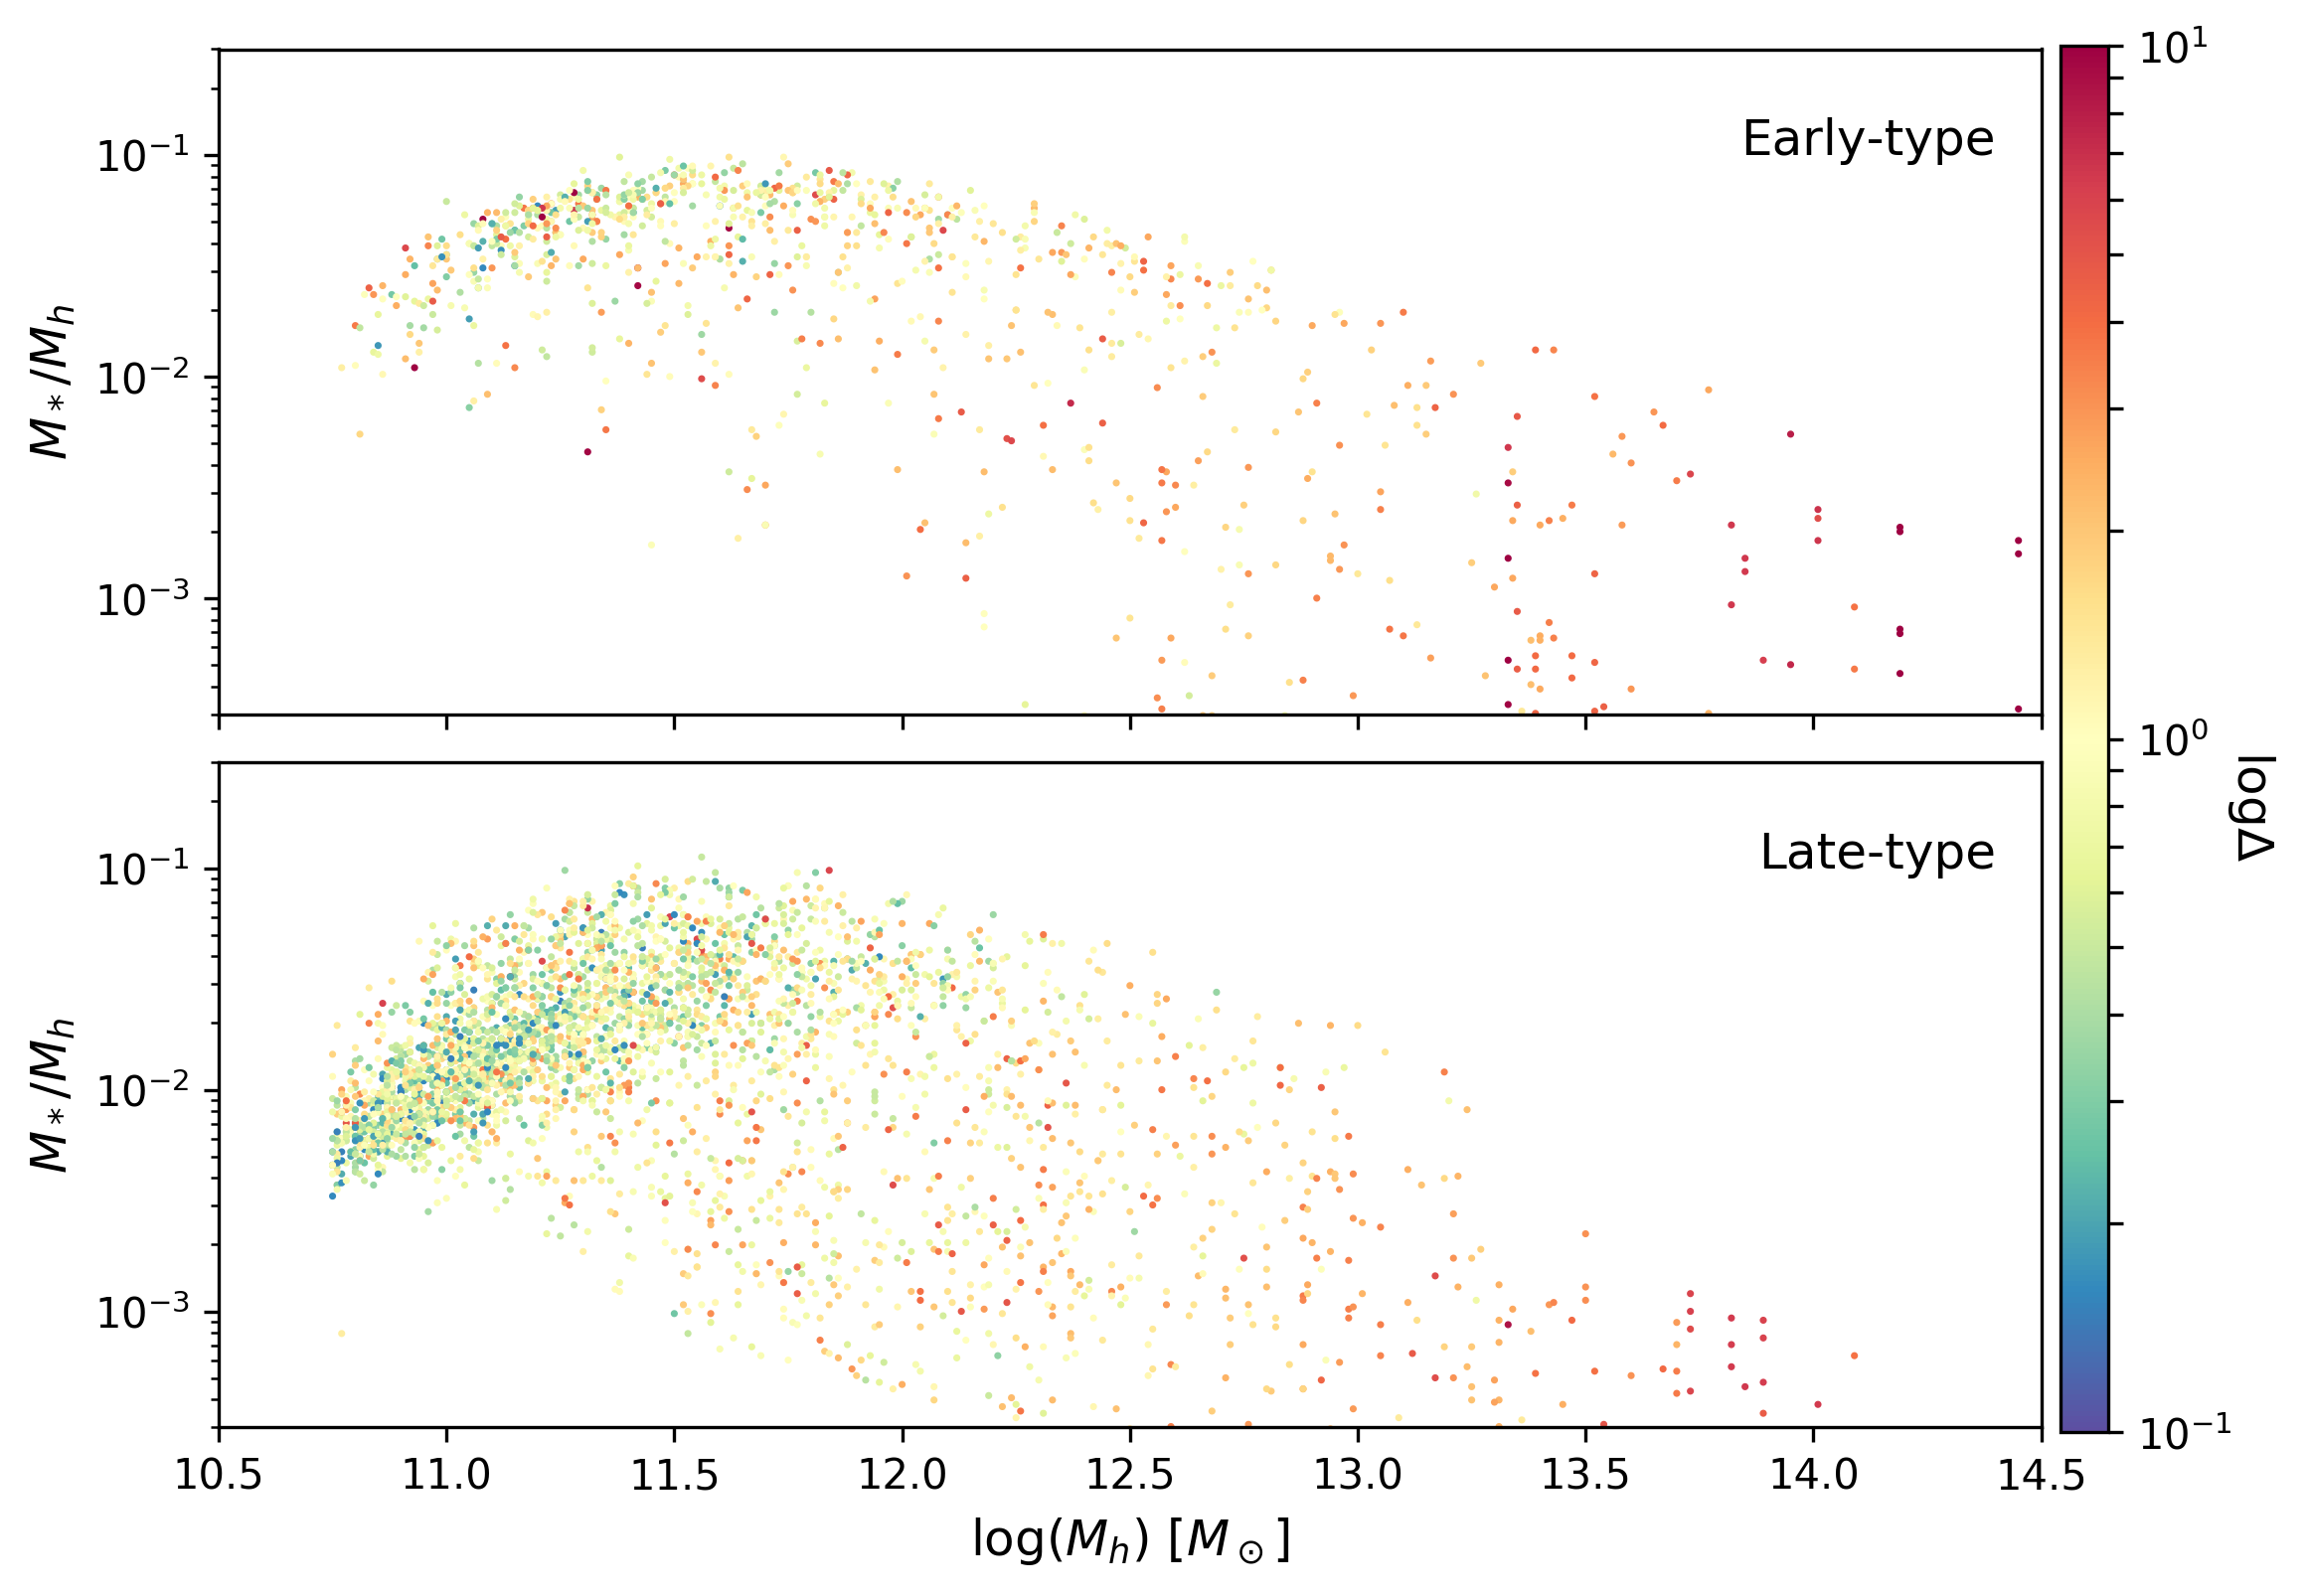

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6), dpi=300, sharex=True)

for ax, m in zip(axes.flat, ['E', 'L']):
    morphology = baryons[baryons.M == m]
    
    morph_label = 'Early-type' if m == 'E' else 'Late-type'
    
    im = ax.scatter('logMh', 'stellar_fraction', data=morphology, s=0.5, c='Den', 
                    cmap=matplotlib.cm.Spectral_r, norm=colors.LogNorm(vmin=0.1, vmax=10))
    

    ax.set_ylabel('$M_*/M_h$', size=12)
    ax.set_yscale('log')
    ax.set_ylim(3e-4, 0.3)
    
    ax.text(14.4, 0.1, morph_label, size=12, ha='right')
    
ax.set_xlim(10.5, 14.5)
ax.set_xlabel('log($M_h$) [$M_\odot$]', size=12)
fig.tight_layout(h_pad=1., rect=[0.05, 0.05, 0.95, 0.95]);

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.775])
fig.colorbar(im, cax=cbar_ax)

cb_ax.grid(axis='y', which='major', ls='-', c='black', lw=0.1)
cb_ax.tick_params(which='both', axis='both', length=0)
fig.text(1.0, 0.5, '$\log\Delta$', fontsize=12, rotation=270, va='center', ha='center')

**Interesting**: the $u-J$ color seems to segregate $M_*/M_h$ ($\sim f_b$, although we don't know the gas mass) as a function of halo mass better than the density. I would have expected the opposite because the baryon fraction seems to be related more to the environmental density than the color $\propto$ SFR (which, perhaps naively, I consider to be a mixture of secular and environmental effects).

Let's now repeat except with *only central galaxies*.

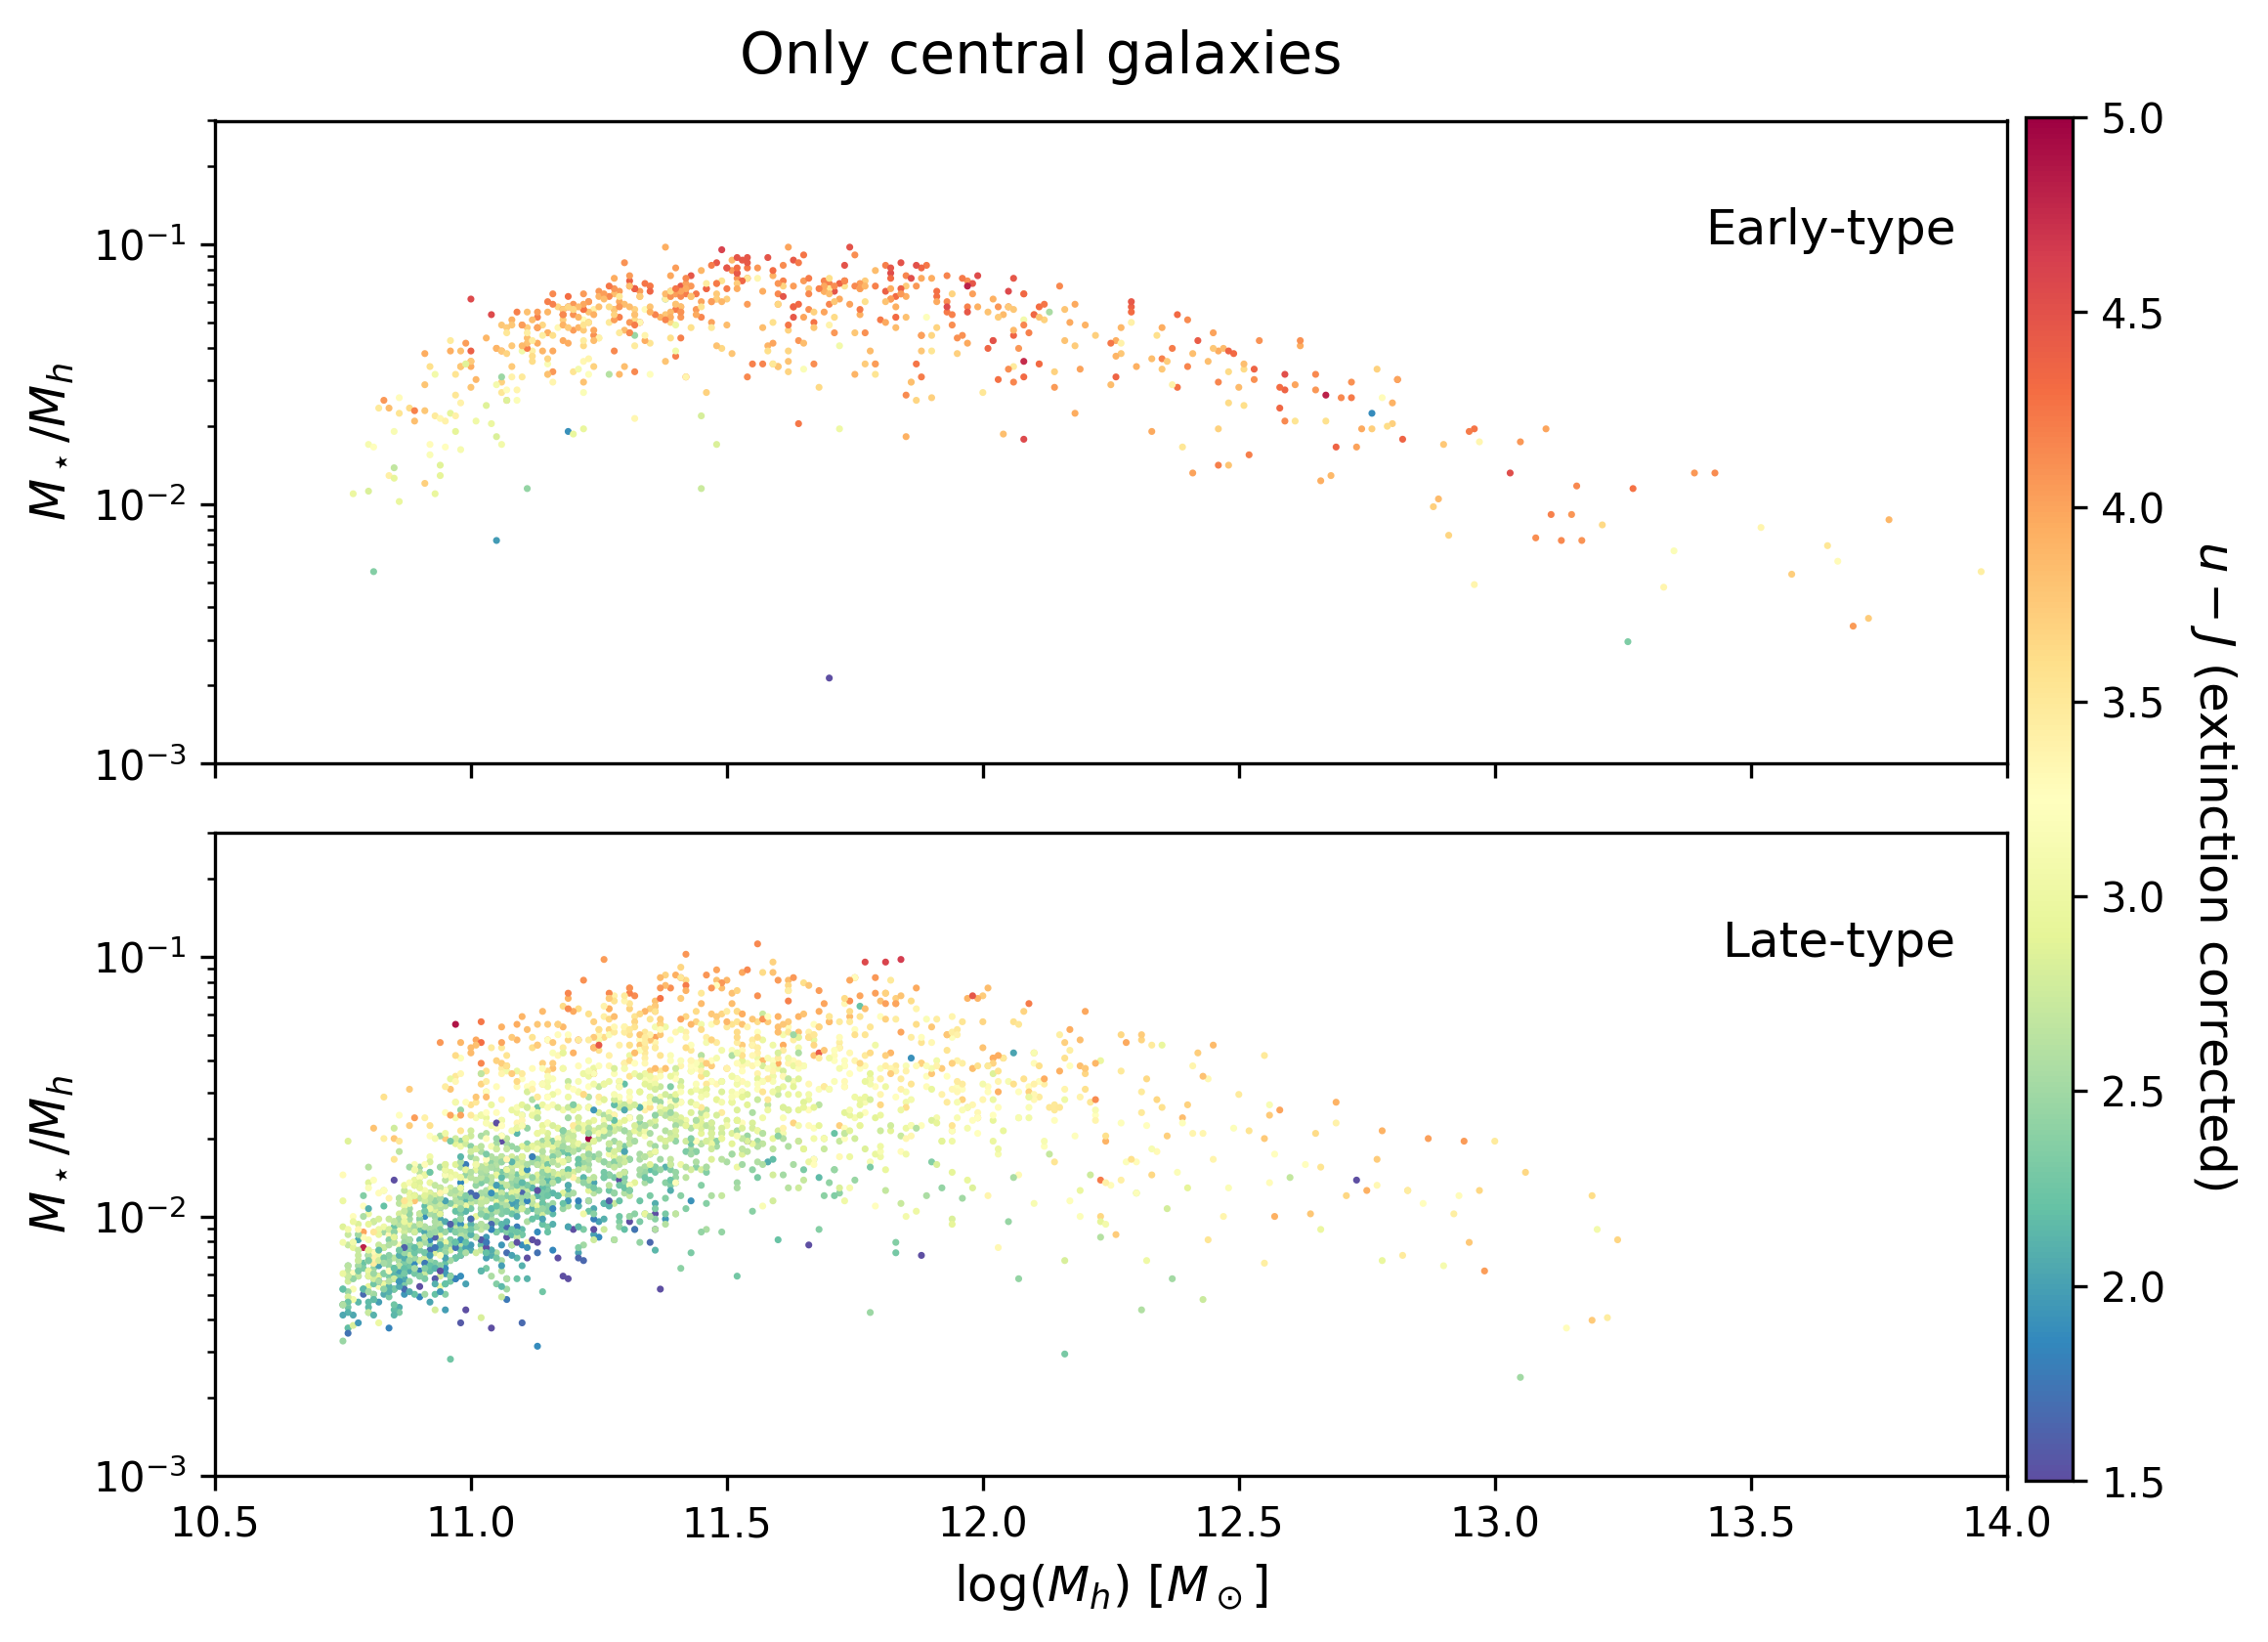

In [8]:
baryons = df[(df.M != '-') & (10 > df['u-J']) 
             & (df['u-J'] > -10) & (df['Den'] > 0)][['u-J', 'logM', 'logMh', 'Den', 'M', 'FC']]

baryons['stellar_fraction'] = np.power(10, baryons.logM) / np.power(10, baryons.logMh)
centrals = baryons[baryons.FC == 1]

fig, axes = plt.subplots(2, 1, figsize=(8, 6), dpi=300, sharex=True, squeeze=True)
for ax, m in zip(axes.flat, ['E', 'L']):
    morphology = centrals[centrals.M == m]
    
    morph_label = 'Early-type' if m == 'E' else 'Late-type'
    
    im = ax.scatter('logMh', 'stellar_fraction', data=morphology, s=0.5, c='u-J', 
                    cmap=matplotlib.cm.Spectral_r, vmin=1.5, vmax=5.0)
    

    ax.set_ylabel('$M_\star/M_h$', size=12)
    ax.set_yscale('log')
    ax.set_ylim(1e-3, 0.3)
    
    ax.text(13.9, 0.1, morph_label, size=12, ha='right')
    
ax.set_xlim(10.5, 14)
ax.set_xlabel('log($M_h$) [$M_\odot$]', size=12)

fig.text(0.5, 0.95, 'Only central galaxies', ha='center', size=14)

# note: tight_layout needs to be set *before* the colorbar
fig.tight_layout(h_pad=1., rect=[0.05, 0.05, 0.95, 0.95]);

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.775])
fig.colorbar(im, cax=cbar_ax)

cb_ax.grid(axis='y', which='major', ls='-', c='black', lw=0.1)
cb_ax.tick_params(which='both', axis='both', length=0)
fig.text(1.0, 0.5, '$u-J$ (extinction corrected)', fontsize=12, rotation=270, va='center', ha='center')

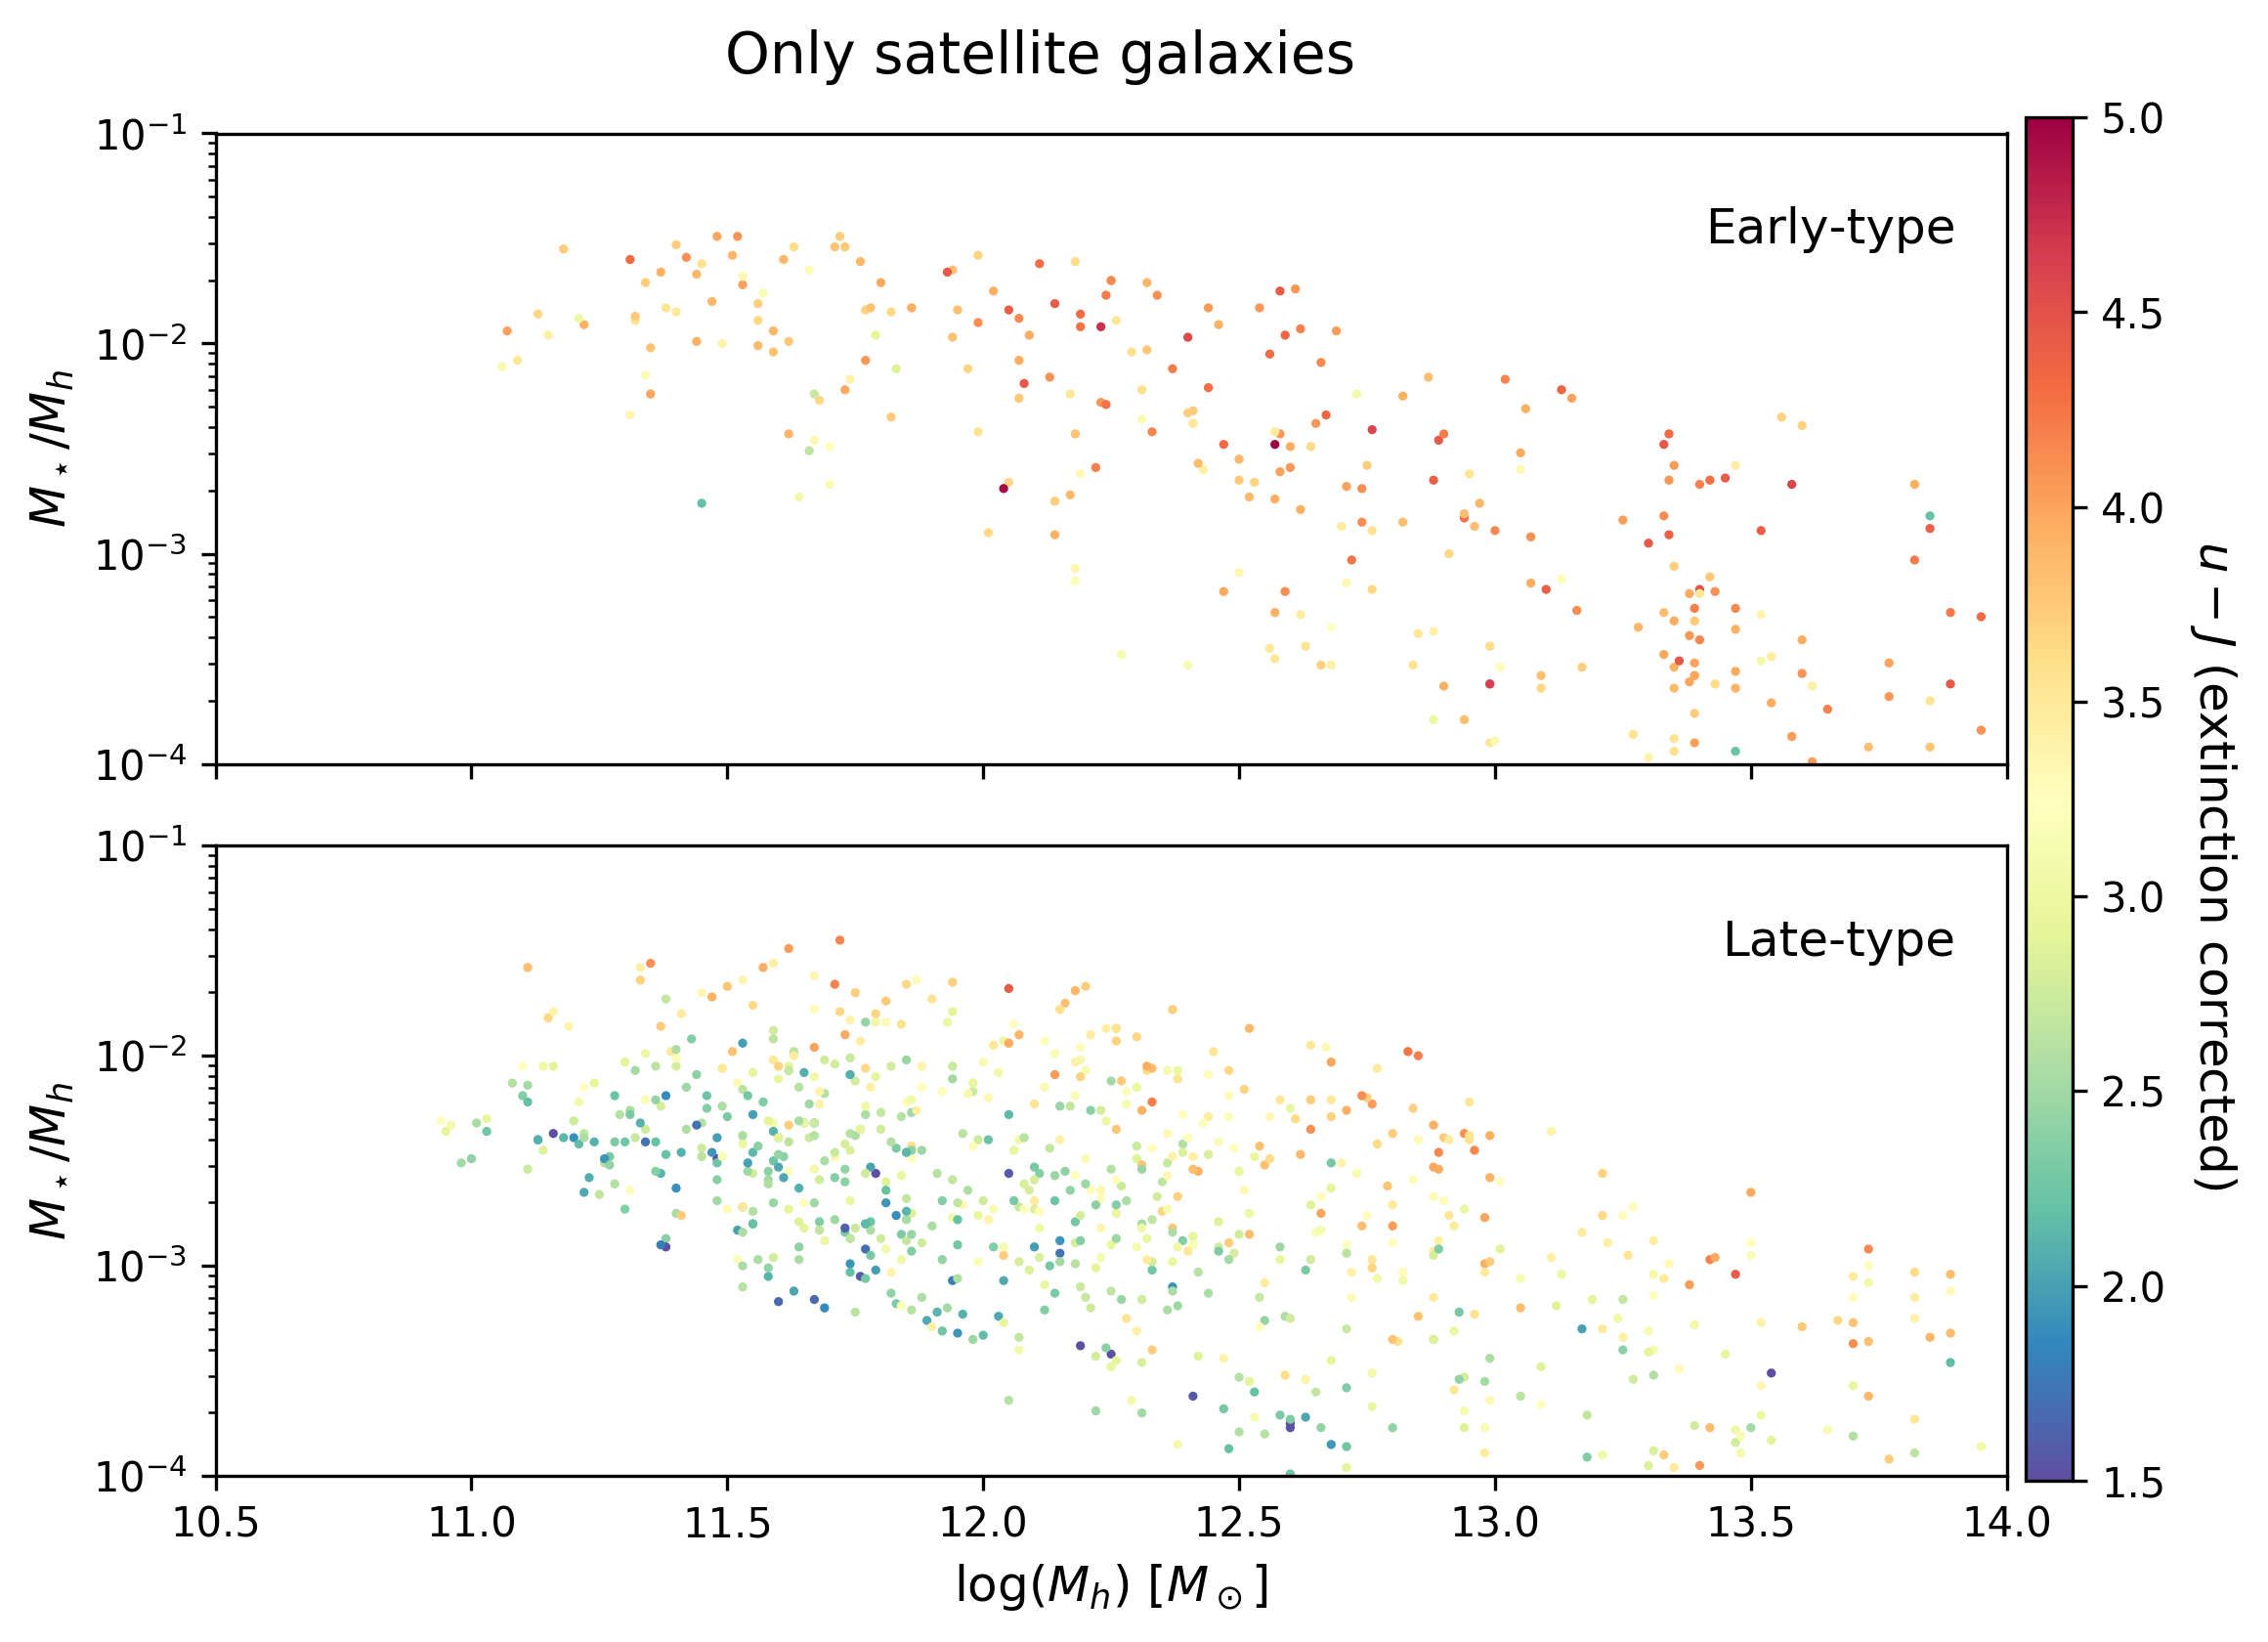

In [9]:
satellites = baryons[baryons.FC == 0]

fig, axes = plt.subplots(2, 1, figsize=(8, 6), dpi=300, sharex=True, squeeze=True)
for ax, m in zip(axes.flat, ['E', 'L']):
    morphology = satellites[satellites.M == m]
    
    morph_label = 'Early-type' if m == 'E' else 'Late-type'
    
    im = ax.scatter('logMh', 'stellar_fraction', data=morphology, s=1.5, c='u-J', 
                    cmap=matplotlib.cm.Spectral_r, vmin=1.5, vmax=5.0)
    

    ax.set_ylabel('$M_\star/M_h$', size=12)
    ax.set_yscale('log')
    ax.set_ylim(1e-4, 0.1)
    
    ax.text(13.9, 0.03, morph_label, size=12, ha='right')
    
ax.set_xlim(10.5, 14)
ax.set_xlabel('log($M_h$) [$M_\odot$]', size=12)

fig.text(0.5, 0.95, 'Only satellite galaxies', ha='center', size=14)

# note: tight_layout needs to be set *before* the colorbar
fig.tight_layout(h_pad=1., rect=[0.05, 0.05, 0.95, 0.95]);

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.775])
fig.colorbar(im, cax=cbar_ax)

cb_ax.grid(axis='y', which='major', ls='-', c='black', lw=0.1)
cb_ax.tick_params(which='both', axis='both', length=0)
fig.text(1.0, 0.5, '$u-J$ (extinction corrected)', fontsize=12, rotation=270, va='center', ha='center')

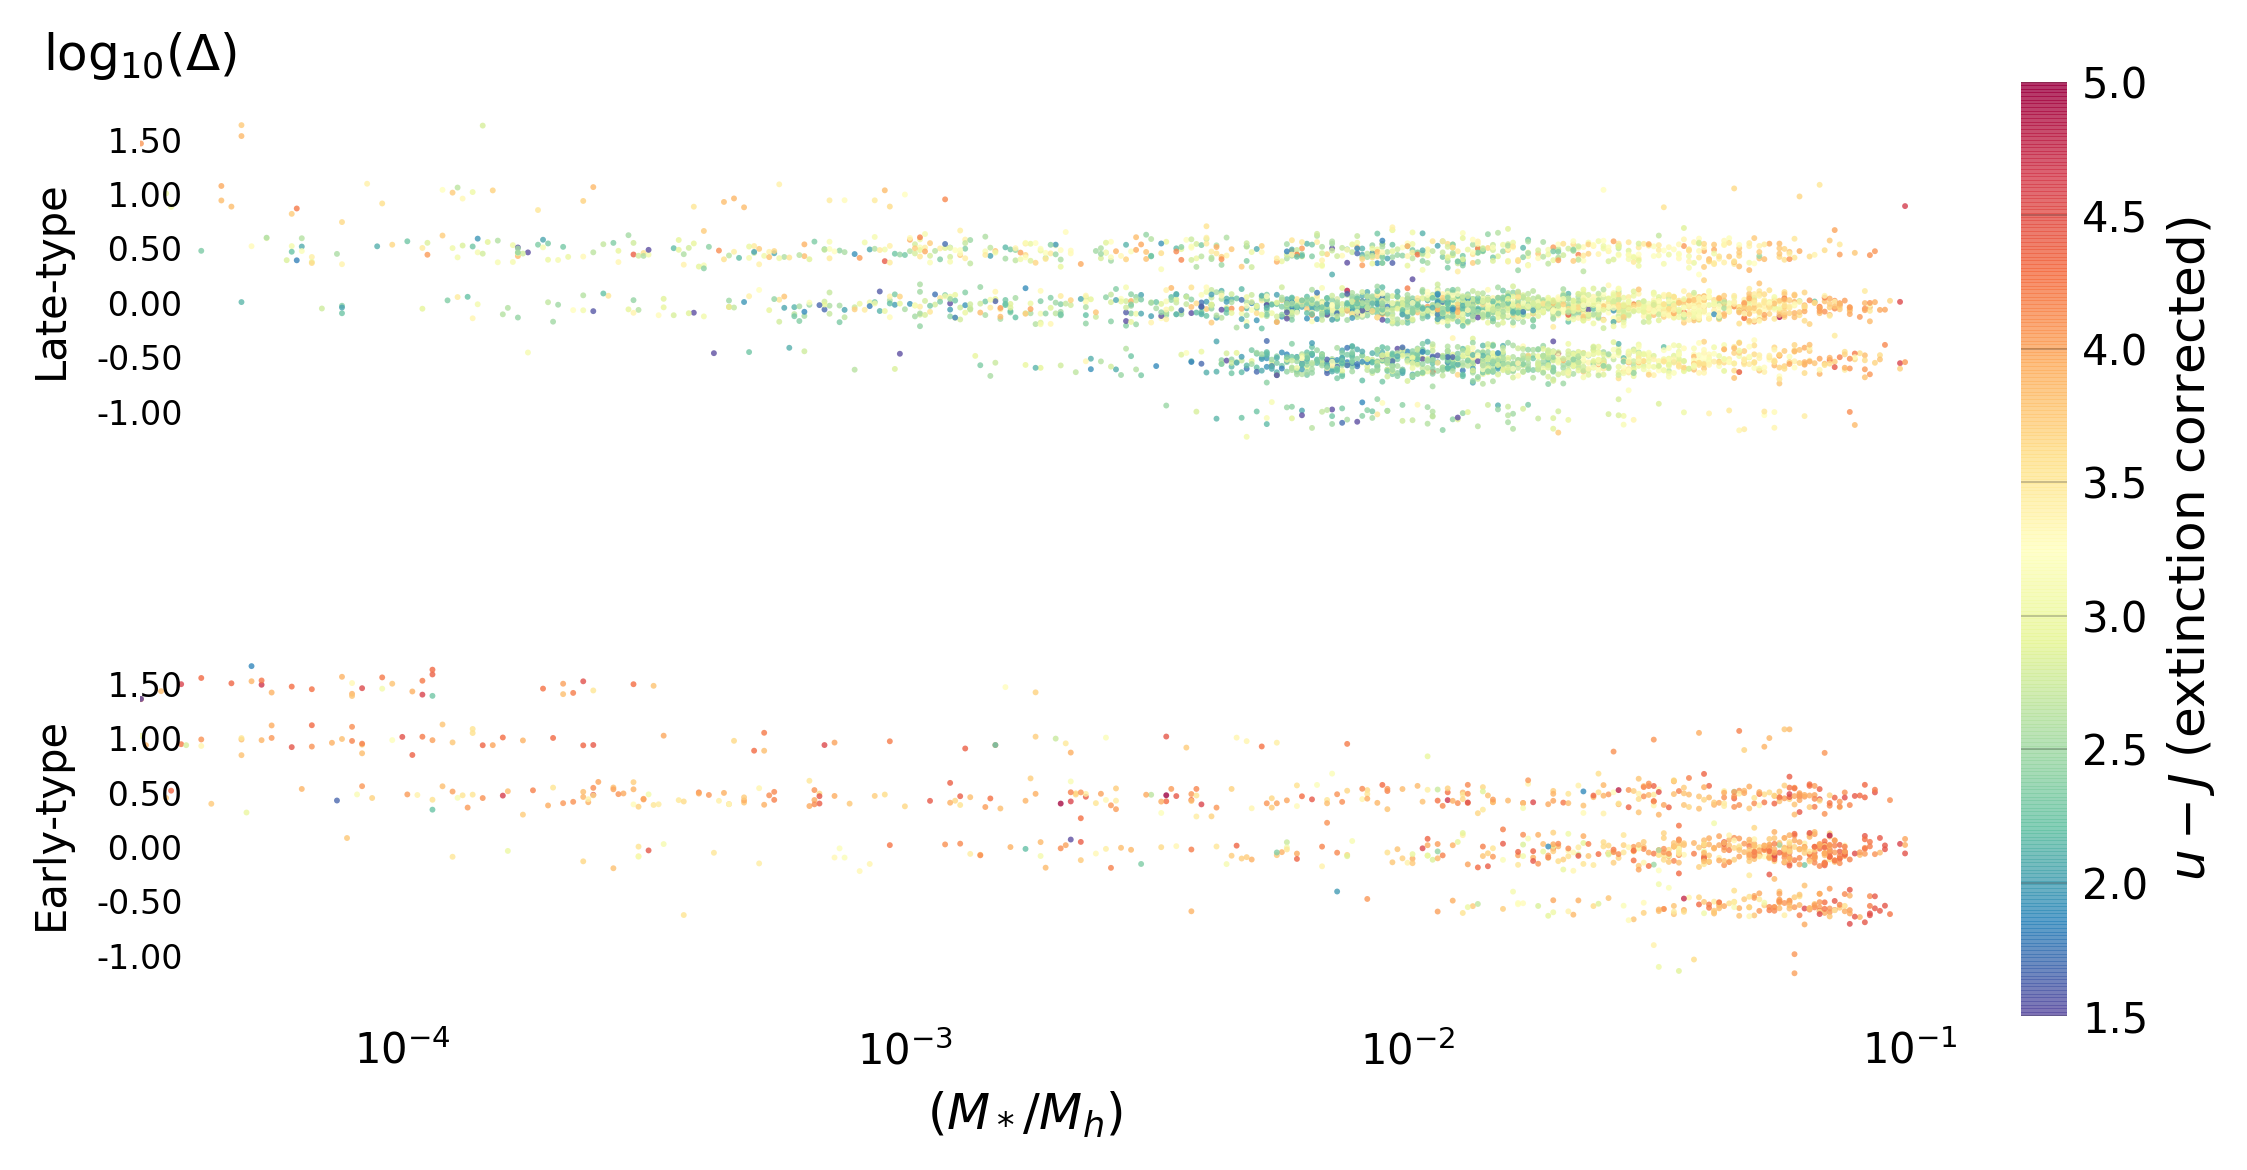

In [10]:
morphologies = df[(df.M != '-') & (10 > df['u-J']) & 
                  (df['u-J'] > -10) & (df['Den'] > 0)].groupby('M')[['u-J', 'Den']]

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)

vmin, vmax = 1.5, 5
num_density_bins = 6

for i, [name, group] in enumerate(morphologies):
    morphology = group[['u-J', 'Den', 'logM', 'logMh']]
    
    stellar_fraction = np.power(10, morphology.logM) / np.power(10, morphology.logMh)
    
    # plot log density 
    log_density = np.log10(morphology['Den'])
    
    for j in xrange(num_density_bins):
        
        log_density_min, log_density_max = -1.25 + j*0.5, -0.75 + j*0.5
        
        morphology_slice = morphology[(log_density > log_density_min) & (log_density < log_density_max)]
        stellar_fraction_slice = stellar_fraction[(log_density > log_density_min) & (log_density < log_density_max)]
        
        # text for log density 
        y0 = i + (j*0.1 - num_density_bins*0.075)
        ax.text(3e-5, y0, r'{: .2f}'.format(log_density_min + 0.25), va='center', ha='center', fontsize=8)
        
        # actually plot
        y = y0 + np.random.randn(len(morphology_slice)) * 1.5e-2
        x = stellar_fraction_slice
        c = morphology_slice['u-J'].as_matrix()

        im = ax.scatter(x, y, c=c, s=2.0, cmap=matplotlib.cm.Spectral_r, 
                        vmin=vmin, vmax=vmax, alpha=0.8, edgecolors='none')

        
# label morphologies
ax.text(2e-5, 0.8, 'Late-type', fontsize=10, ha='center', va='center', rotation=90)
ax.text(2e-5, -0.2, 'Early-type', fontsize=10, ha='center', va='center', rotation=90)


ax.set_yticks([])
ax.set_ylabel(r'$\log_{10}(\Delta)$', rotation=0, fontsize=12)
ax.yaxis.set_label_coords(0., 1.)

# remove borders
[spine.set_visible(False) for spine in ax.spines.itervalues()]

ax.set_xlim(3e-5, 0.1)
ax.set_xscale('log')
ax.set_xlabel('$(M_*/M_h)$', fontsize=12)
ax.tick_params(which='both', axis='both', length=0)

cb = fig.colorbar(im, )
cb.outline.set_visible(False)
cb_ax = cb.ax
cb_ax.grid(axis='y', which='major', ls='-', c='black', lw=0.1)
cb_ax.tick_params(which='both', axis='both', length=0)
cb.set_label('$u-J$ (extinction corrected)', fontsize=12)

fig.tight_layout();

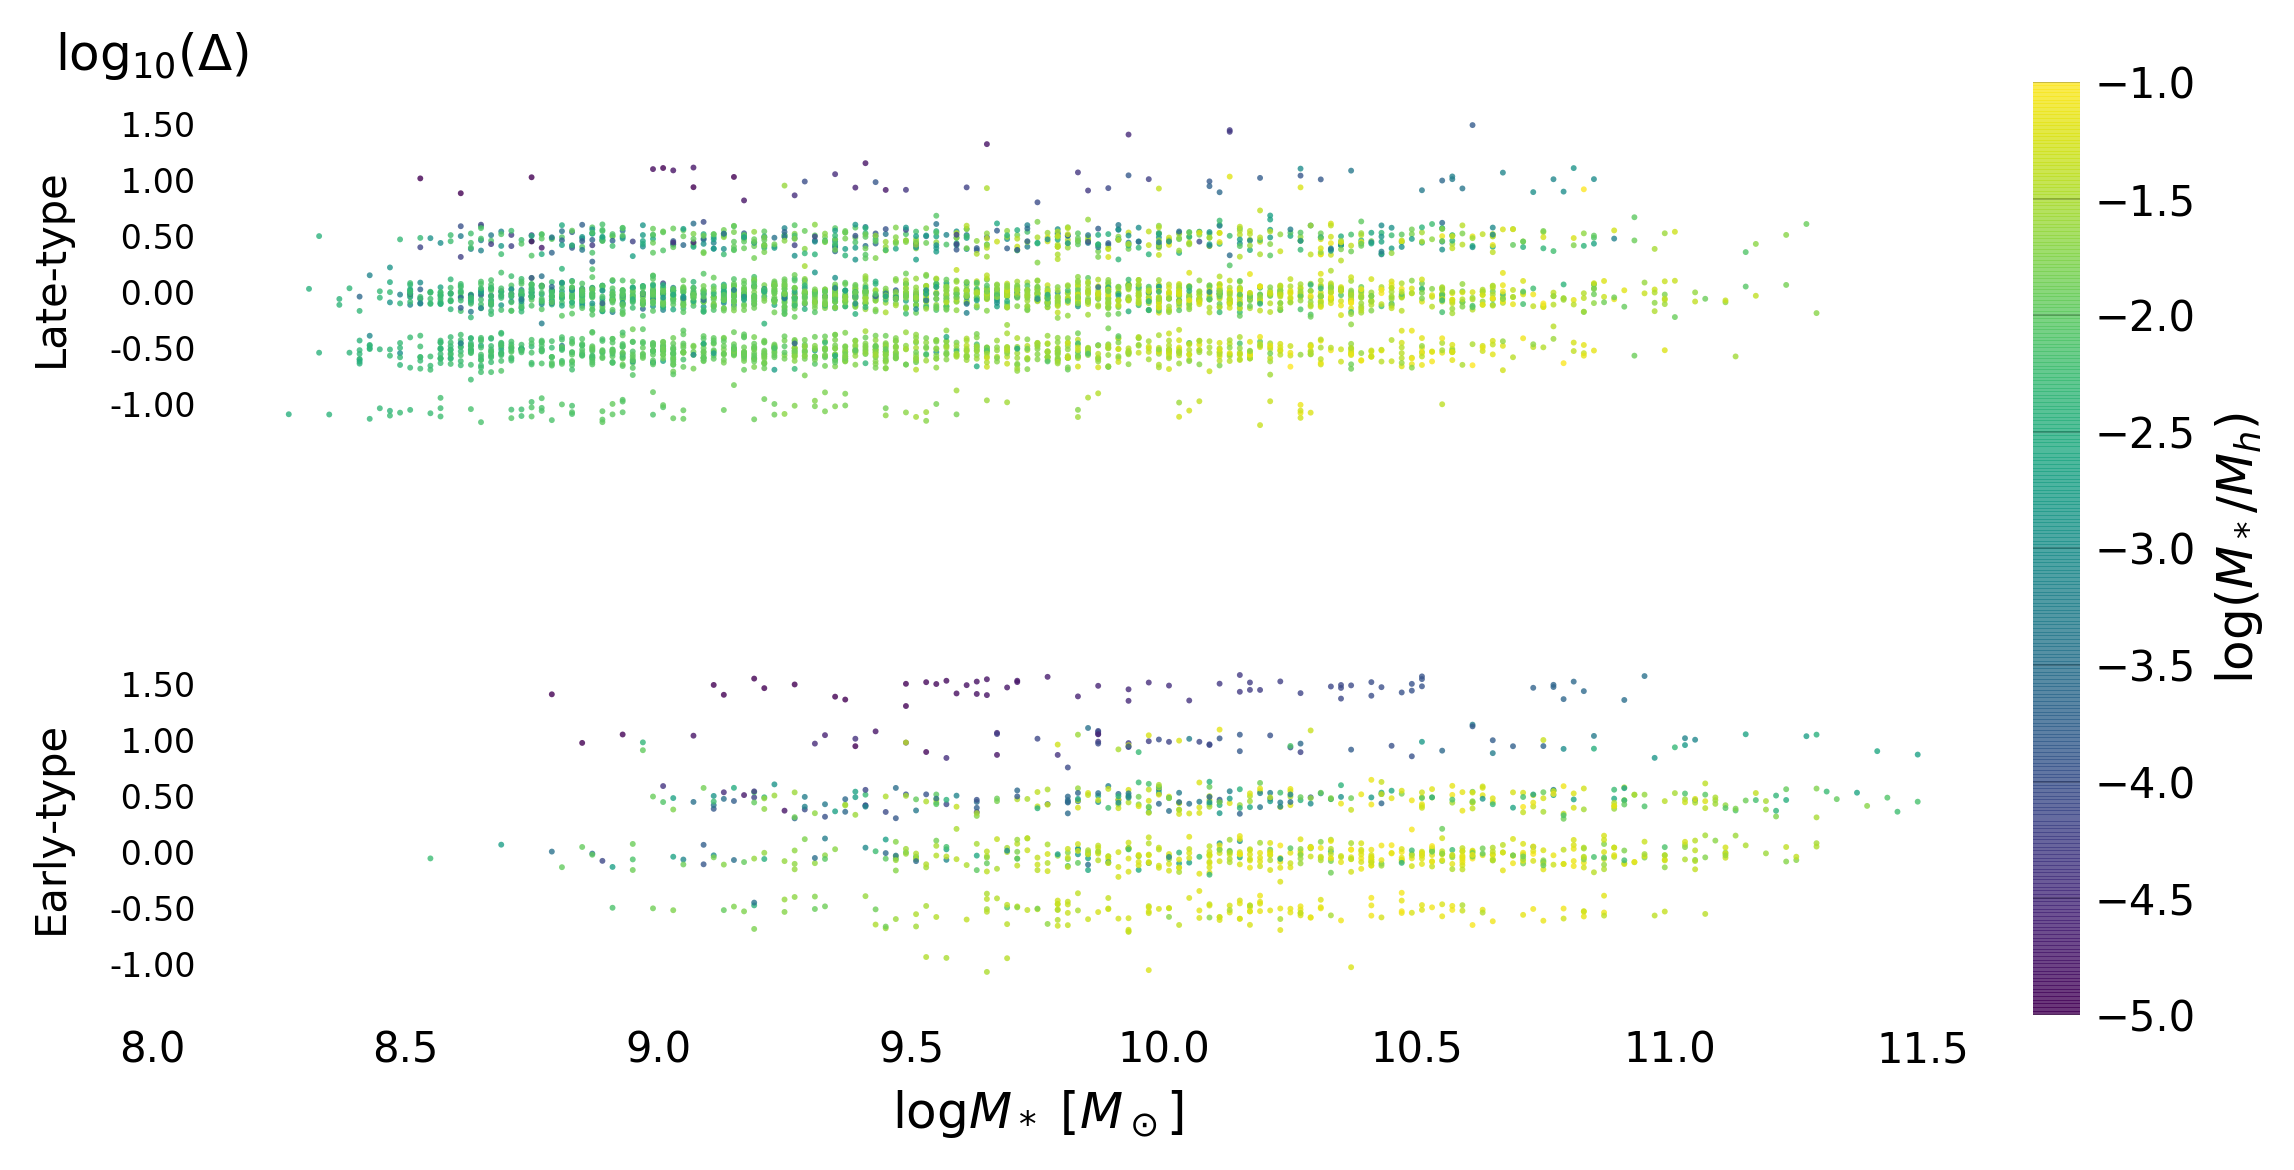

In [11]:
morphologies = df[(df.M != '-') & (10 > df['u-J']) & 
                  (df['u-J'] > -10) & (df['Den'] > 0)].groupby('M')[['u-J', 'Den']]

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)

vmin, vmax = 1.5, 5
num_density_bins = 6

for i, [name, group] in enumerate(morphologies):
    morphology = group[['u-J', 'Den', 'logM', 'logMh']]
    
    log_stellar_fraction = np.log10(np.power(10, morphology.logM) / np.power(10, morphology.logMh))
    
    # plot log density 
    log_density = np.log10(morphology['Den'])
    
    for j in xrange(num_density_bins):
        
        log_density_min, log_density_max = -1.25 + j*0.5, -0.75 + j*0.5
        
        morphology_slice = morphology[(log_density > log_density_min) & (log_density < log_density_max)]
        stellar_fraction_slice = log_stellar_fraction[(log_density > log_density_min) & (log_density < log_density_max)]
        
        # text for log density 
        y0 = i + (j*0.1 - num_density_bins*0.075)
        ax.text(8, y0, r'{: .2f}'.format(log_density_min + 0.25), va='center', ha='center', fontsize=8)
        
        # actually plot
        y = y0 + np.random.randn(len(morphology_slice)) * 1.5e-2
        x = morphology_slice.logM
        c = stellar_fraction_slice

        im = ax.scatter(x, y, c=c, s=2.0, cmap=matplotlib.cm.viridis, 
                        vmin=-5, vmax=-1, alpha=0.8, edgecolors='none')

        
# label morphologies
ax.text(7.8, 0.8, 'Late-type', fontsize=10, ha='center', va='center', rotation=90)
ax.text(7.8, -0.2, 'Early-type', fontsize=10, ha='center', va='center', rotation=90)

ax.set_yticks([])
ax.set_ylabel(r'$\log_{10}(\Delta)$', rotation=0, fontsize=12)
ax.yaxis.set_label_coords(0., 1.)

# remove borders
[spine.set_visible(False) for spine in ax.spines.itervalues()]

ax.set_xlim(8, 11.5)
ax.set_xlabel('$\log M_*$ [$M_\odot$]', fontsize=12)
ax.tick_params(which='both', axis='both', length=0)

cb = fig.colorbar(im, )
cb.outline.set_visible(False)
cb_ax = cb.ax
cb_ax.grid(axis='y', which='major', ls='-', c='black', lw=0.1)
cb_ax.tick_params(which='both', axis='both', length=0)
cb.set_label('$\log (M_*/M_h)$', fontsize=12)

fig.tight_layout();

Does environment really not matter? Seems like it does...

Let's just look at the 2d scatter with color...

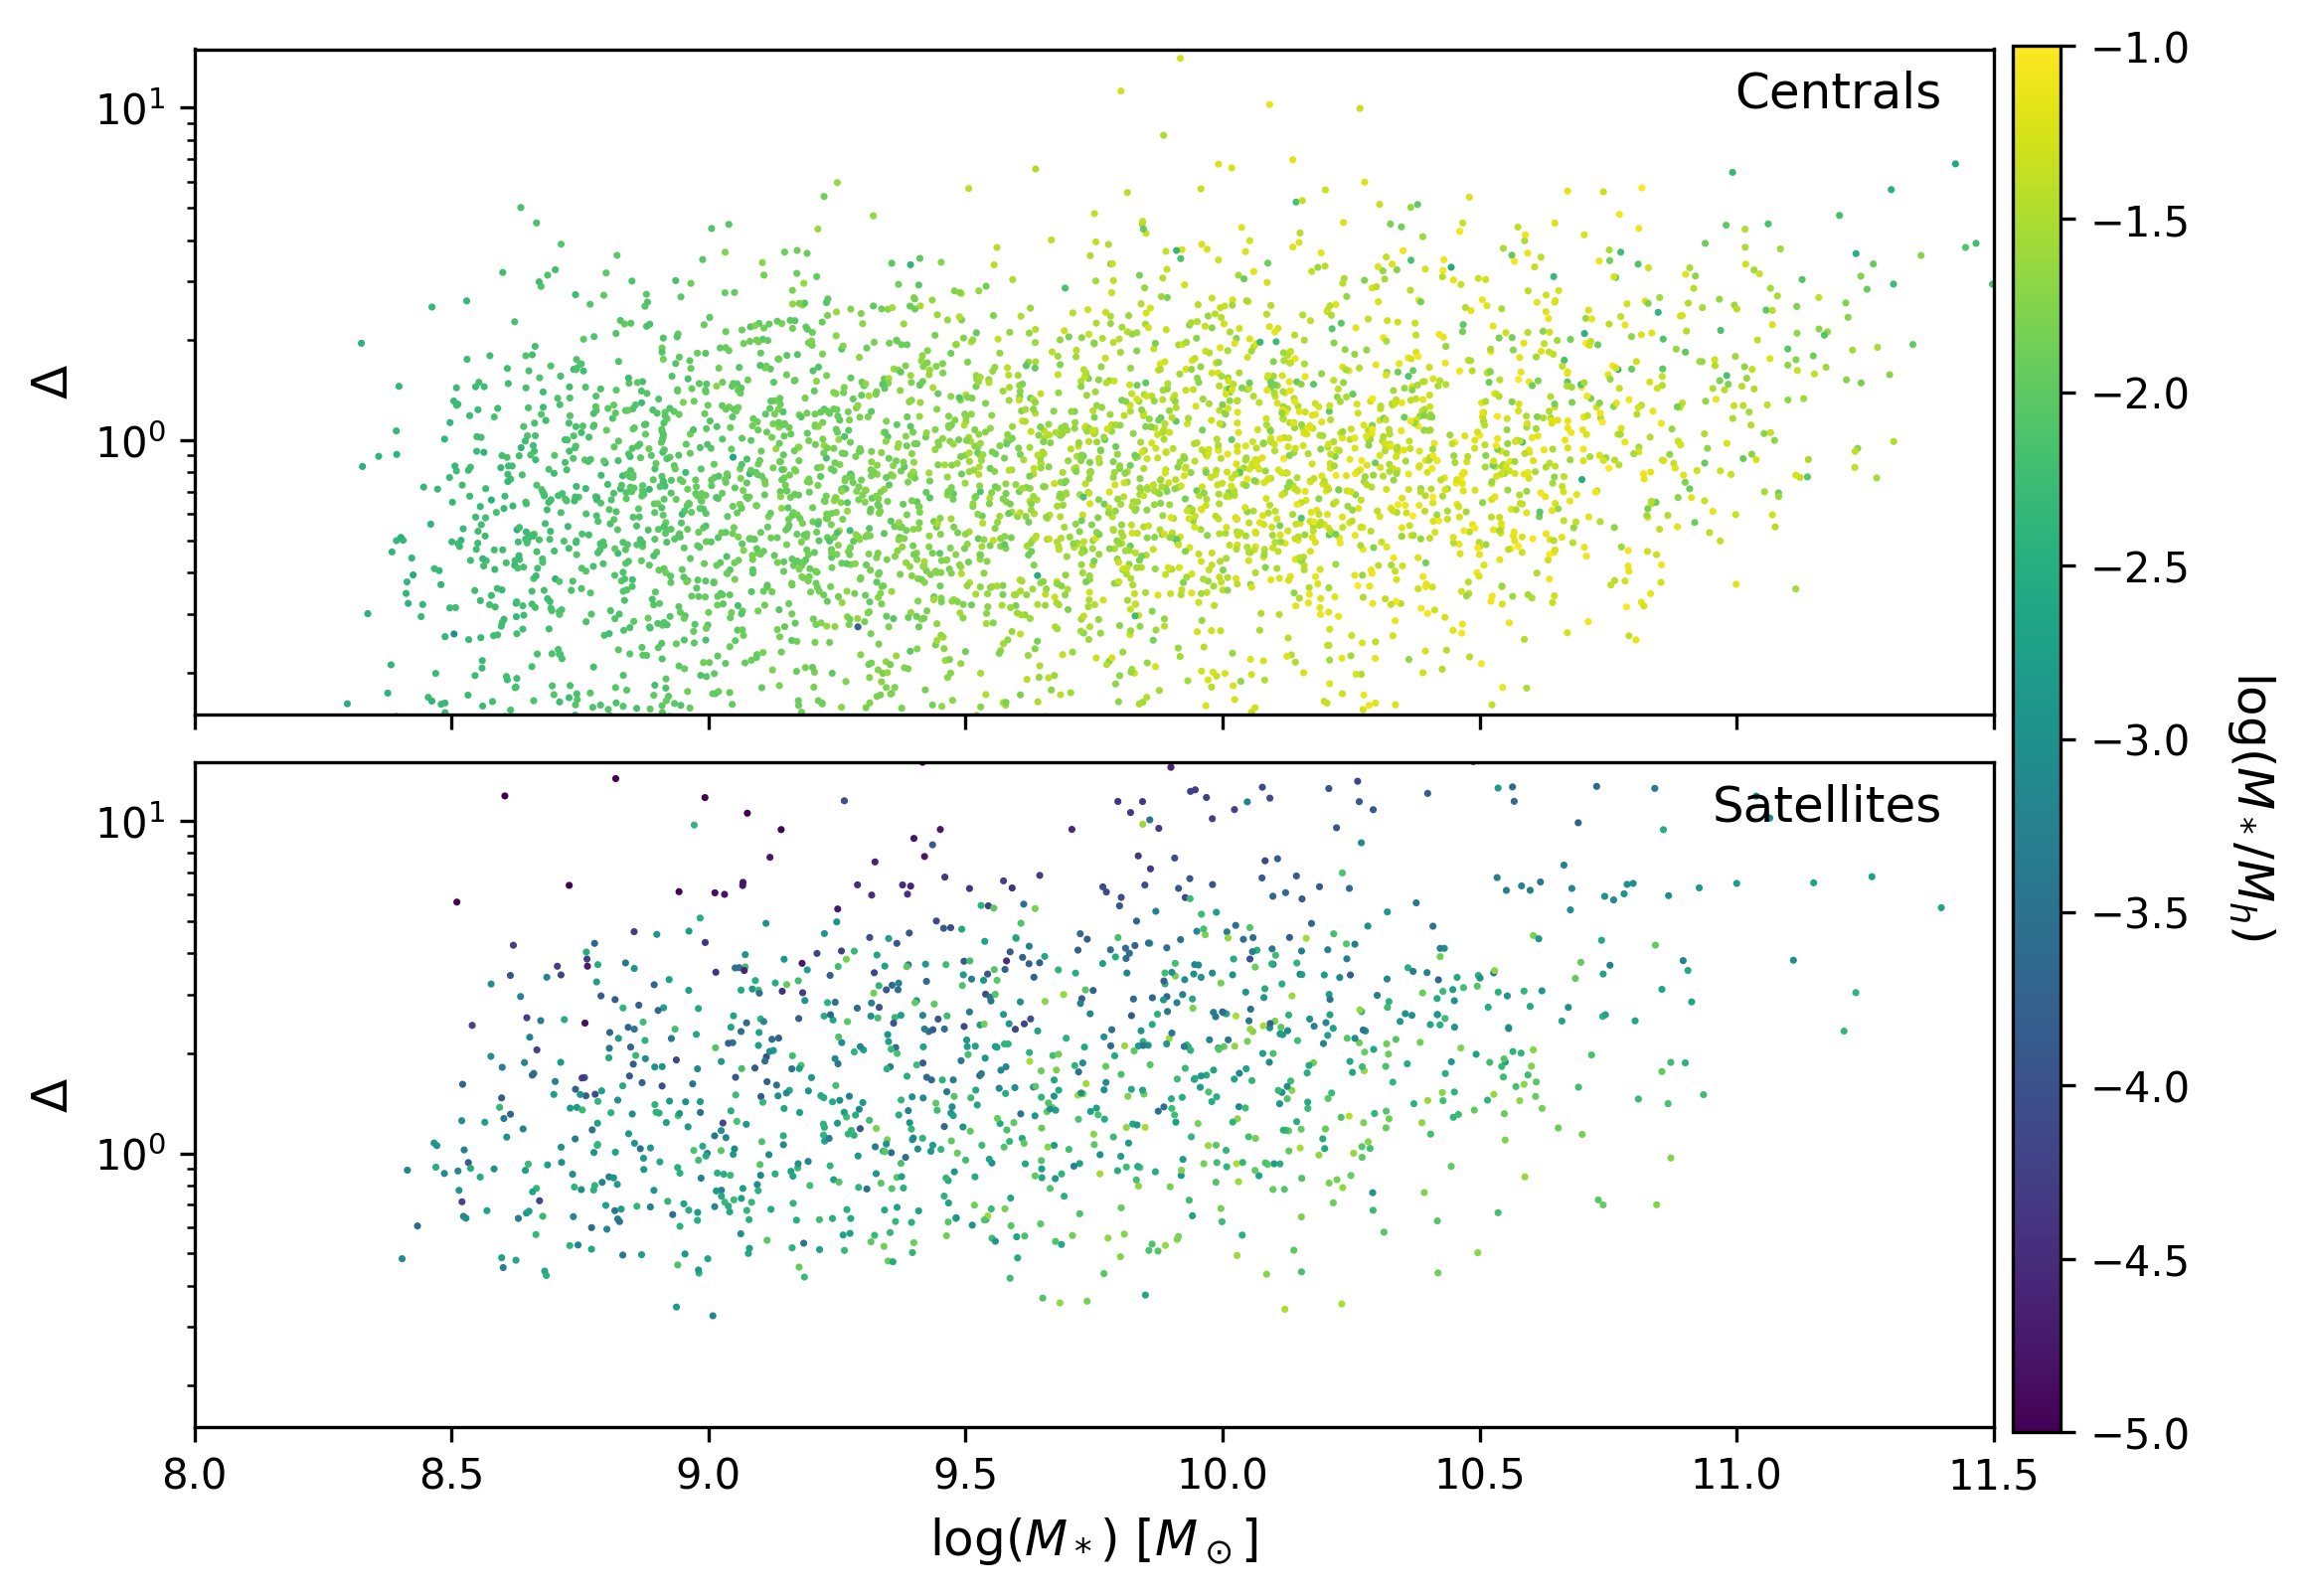

In [17]:
df_clean = df[(df.M != '-') & (10 > df['u-J']) & (df['u-J'] > -10) & (df['Den'] > 0)].copy()
df_clean['log_stellar_fraction'] = df_clean.logM - df_clean.logMh

# add some scatter so points don't overlap
df_clean['Den'] *= (1 + 0.02*np.random.randn(len(df_clean)))
df_clean['logM'] += 0.02*np.random.randn(len(df_clean))

fig = plt.figure(figsize=(8, 6), dpi=300)

fig, axes = plt.subplots(2, 1, figsize=(8, 6), dpi=300, sharex=True, squeeze=True)
for ax, cen in zip(axes.flat, [1, 0]):
    gals = df_clean[df_clean.FC == cen]
    label = 'Centrals' if cen == 1 else 'Satellites'
    
    im = ax.scatter(x='logM', y='Den', data=gals, s=0.5, c='log_stellar_fraction', 
                    cmap=matplotlib.cm.viridis, vmin=-5, vmax=-1)
    
    ax.set_ylabel('$\Delta$', size=12)
    ax.set_yscale('log')
    ax.set_xlim(8, 11.5)
    ax.set_ylim(0.15, 15)
    
    ax.text(11.4, 10., label, size=12, ha='right')
    
ax.set_xlim(8, 11.5)
ax.set_xlabel('log($M_*$) [$M_\odot$]', size=12)

fig.tight_layout(h_pad=1., rect=[0.05, 0.05, 0.93, 0.95]);

cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.775])
fig.colorbar(im, cax=cbar_ax)

cb_ax.grid(axis='y', which='major', ls='-', c='black', lw=0.1)
cb_ax.tick_params(which='both', axis='both', length=0)
fig.text(1.0, 0.5, 'log$(M_*/M_h)$', fontsize=12, rotation=270, va='center', ha='center')

So it looks like central galaxy $M_*/M_h$ are **fully determined by mass** and not environment, whereas the satellite stellar mass ratio **does depend on environmental density**.

Back to color...

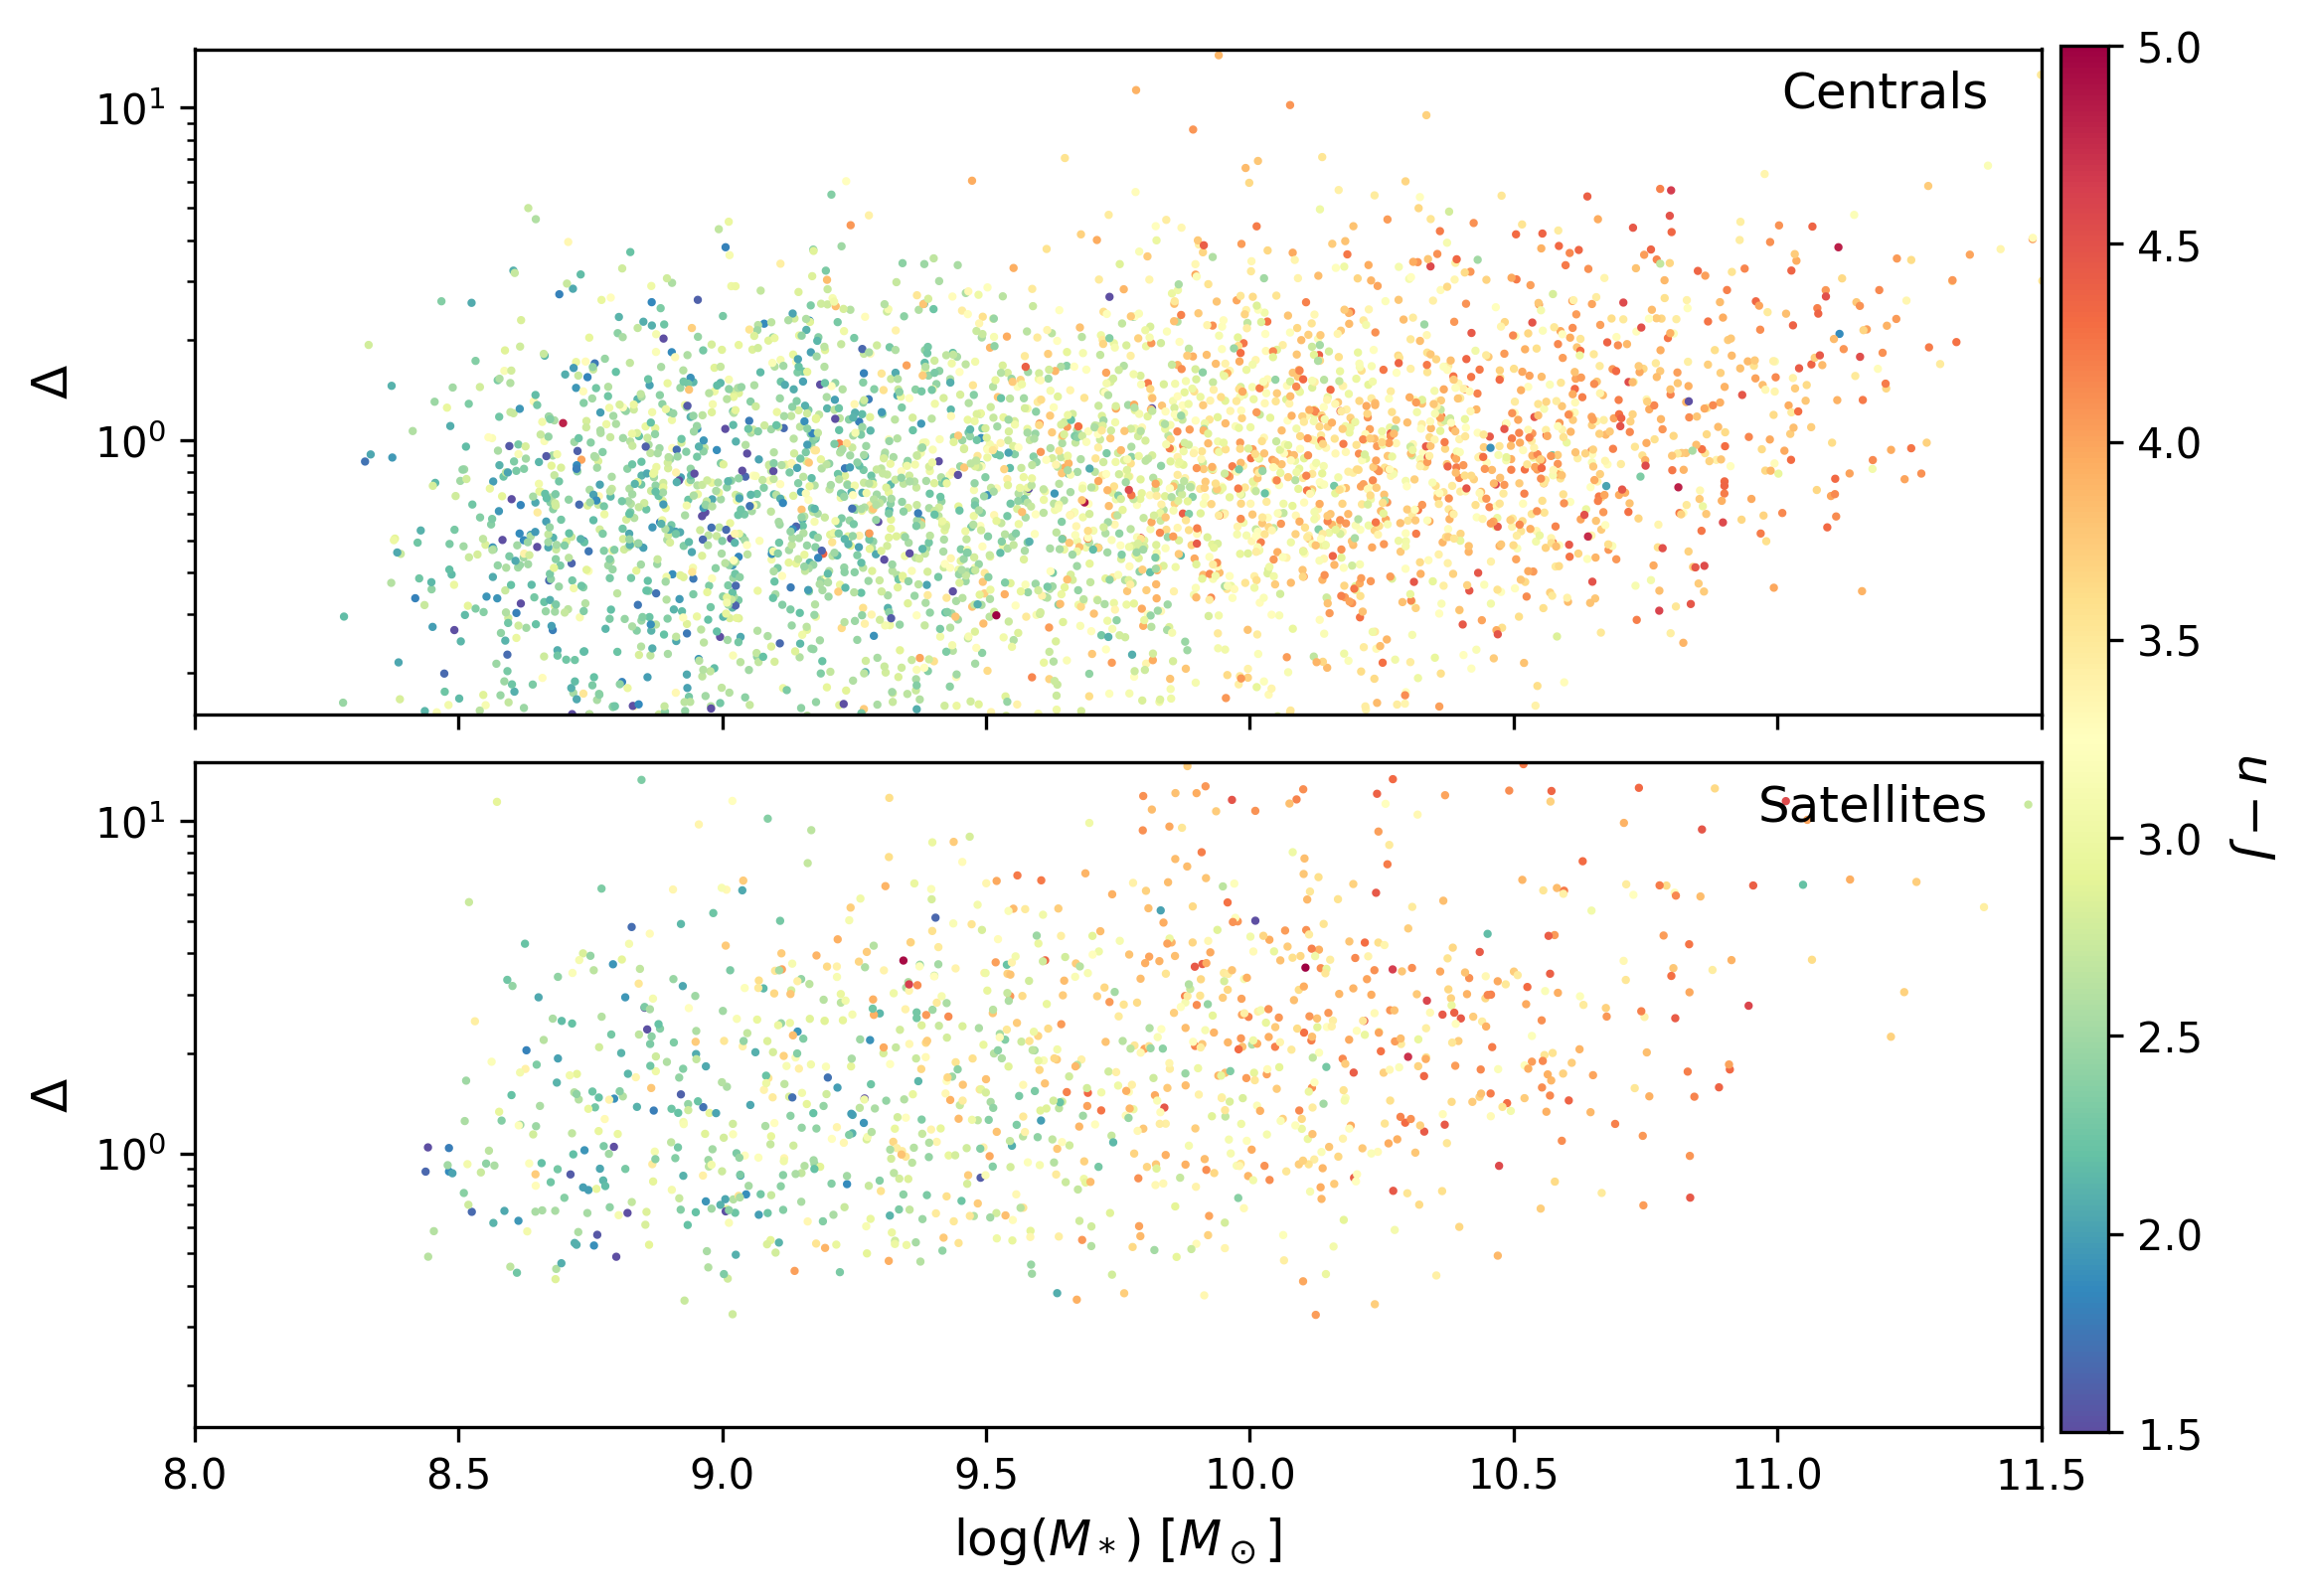

In [19]:
df_clean = df[(df.M != '-') & (10 > df['u-J']) & (df['u-J'] > -10) & (df['Den'] > 0)].copy()

# add some scatter so points don't overlap
df_clean['Den'] *= (1 + 0.02*np.random.randn(len(df_clean)))
df_clean['logM'] += 0.02*np.random.randn(len(df_clean))

fig = plt.figure(figsize=(8, 6), dpi=300)

fig, axes = plt.subplots(2, 1, figsize=(8, 6), dpi=300, sharex=True, squeeze=True)
for ax, cen in zip(axes.flat, [1, 0]):
    gals = df_clean[df_clean.FC == cen]
    label = 'Centrals' if cen == 1 else 'Satellites'
    
    im = ax.scatter(x='logM', y='Den', data=gals, s=1, c='u-J', 
                    cmap=matplotlib.cm.Spectral_r, vmin=1.5, vmax=5)
    
    ax.set_ylabel('$\Delta$', size=12)
    ax.set_yscale('log')
    ax.set_xlim(8, 11.5)
    ax.set_ylim(0.15, 15)
    
    ax.text(11.4, 10., label, size=12, ha='right')
    
ax.set_xlim(8, 11.5)
ax.set_xlabel('log($M_*$) [$M_\odot$]', size=12)

fig.tight_layout(h_pad=1., rect=[0.05, 0.05, 0.95, 0.95]);

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.775])
fig.colorbar(im, cax=cbar_ax)

cb_ax.grid(axis='y', which='major', ls='-', c='black', lw=0.1)
cb_ax.tick_params(which='both', axis='both', length=0)
fig.text(1.0, 0.5, '$u-J$', fontsize=12, rotation=270, va='center', ha='center')

Try making a contour plot of $M_*/M_h$  over $\Delta$ vs. $M_*$ (colors := *mean* $u-J$).

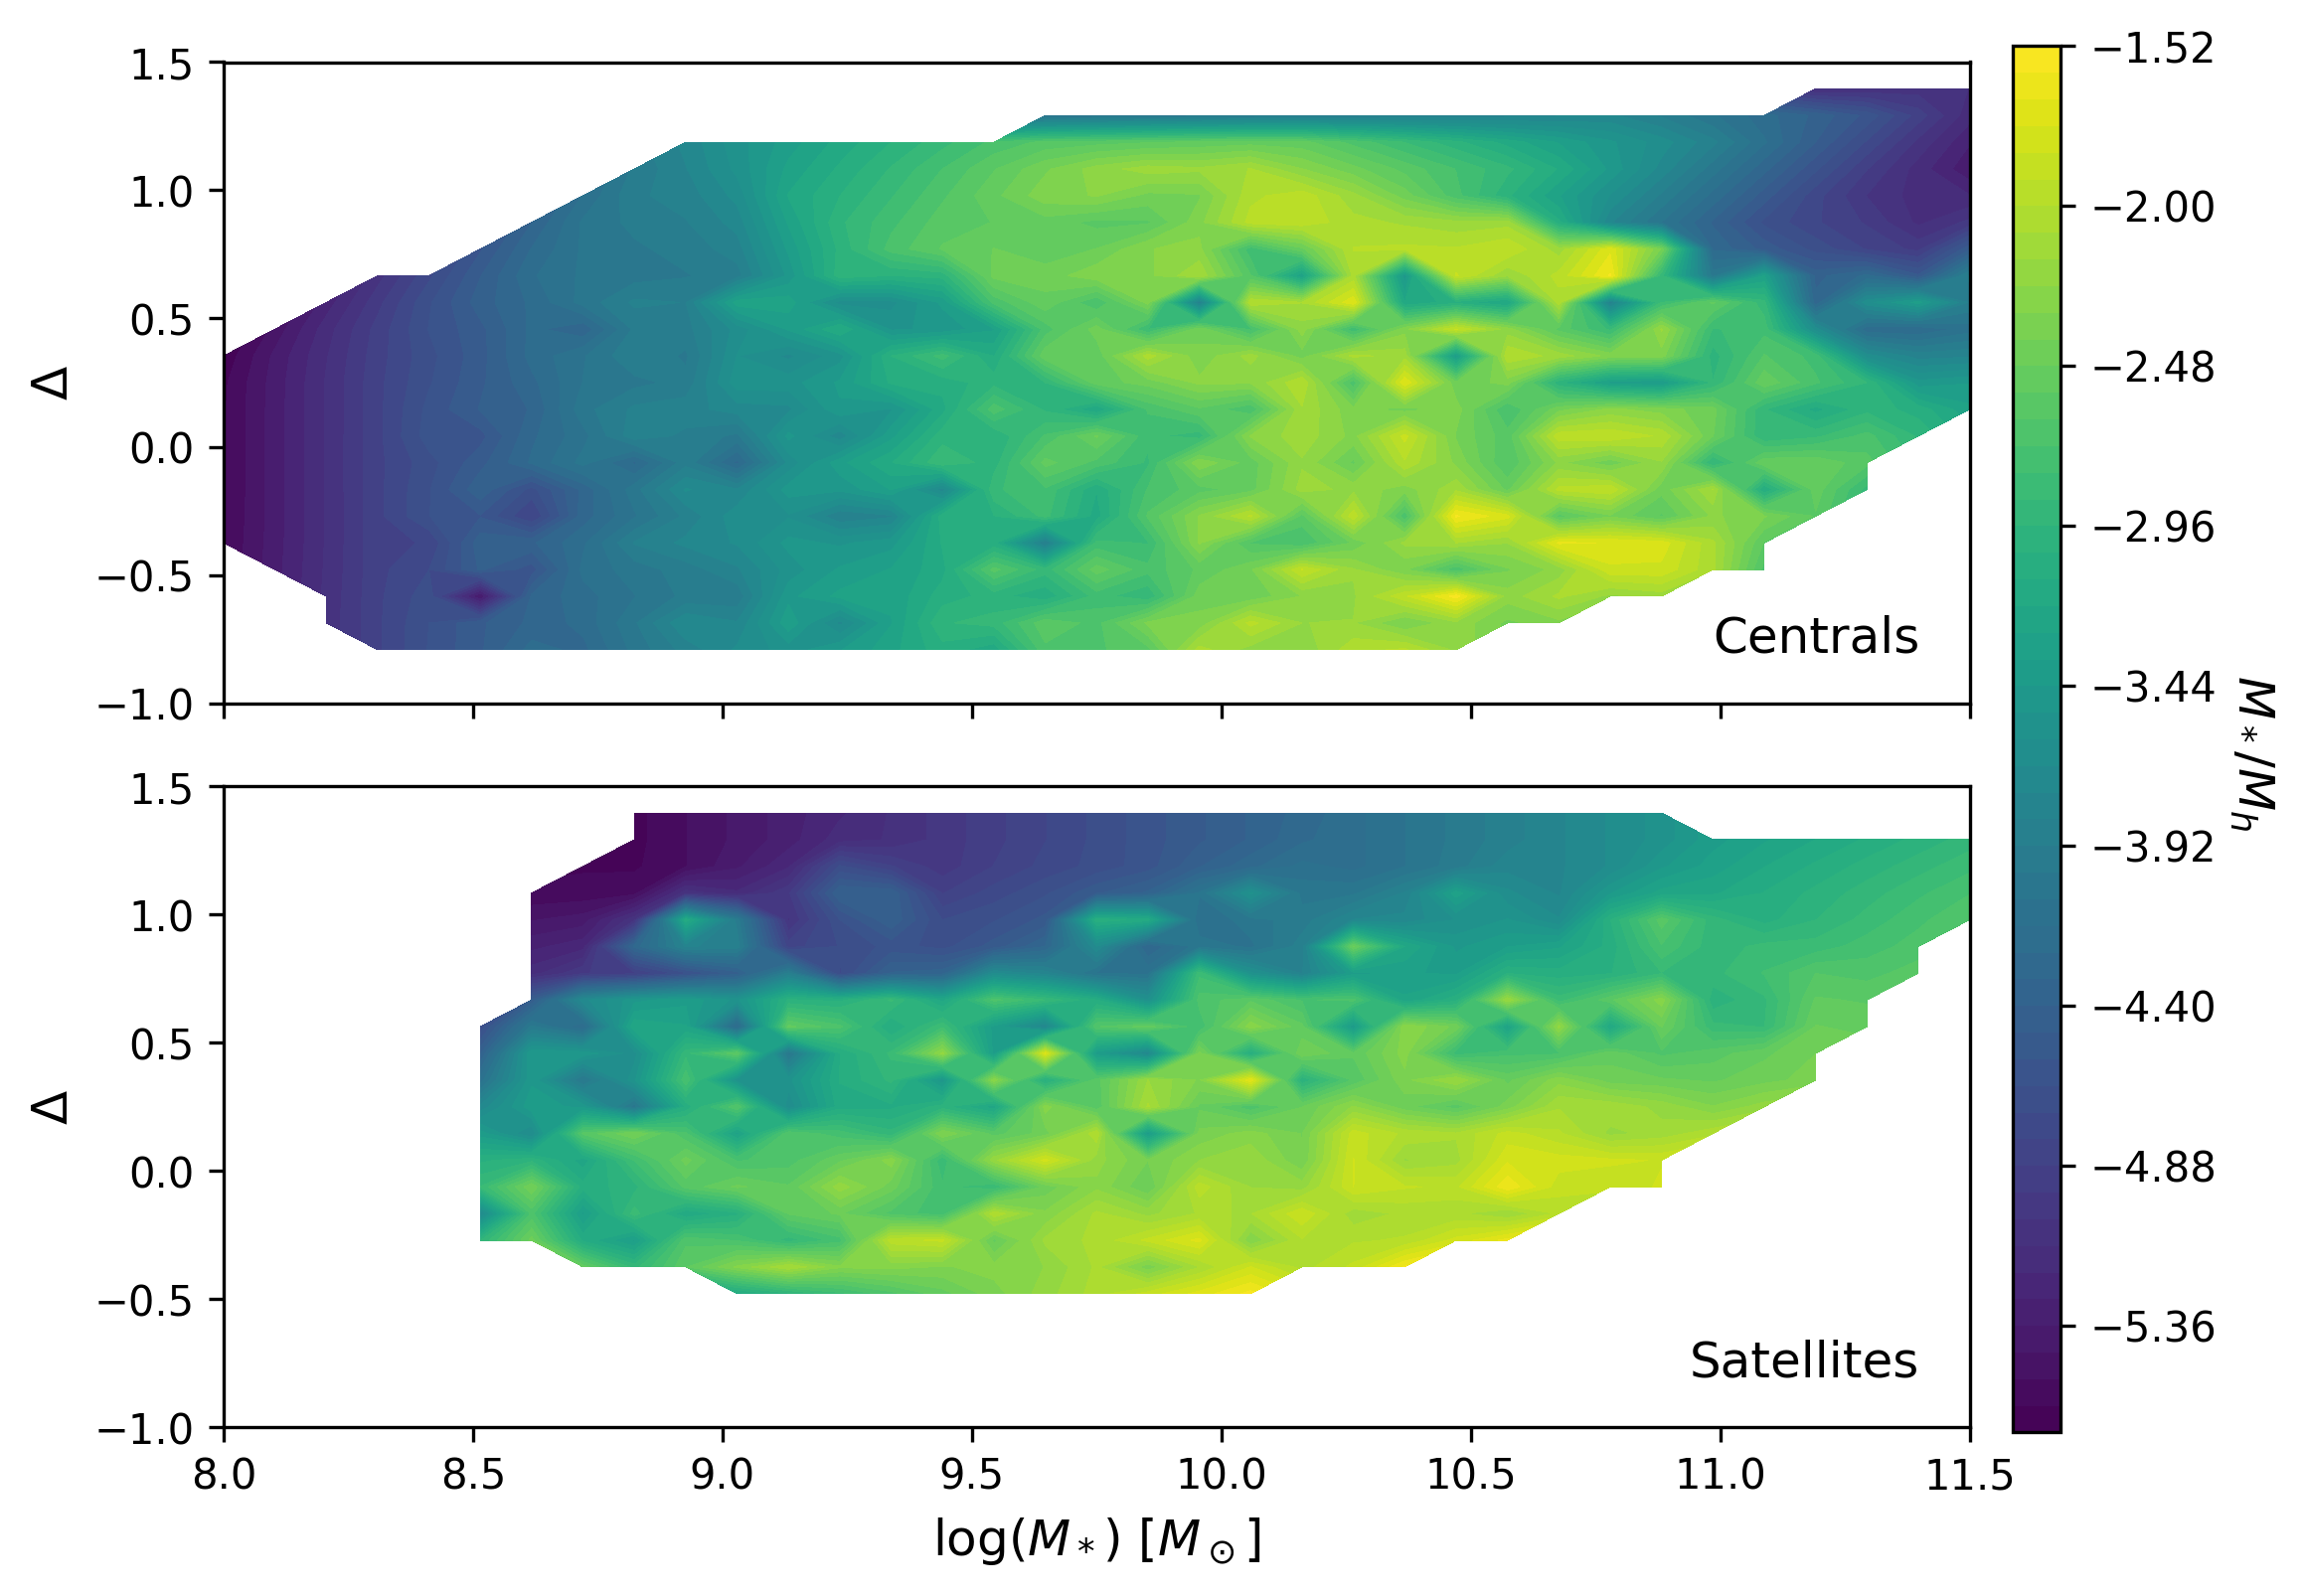

In [37]:
df_clean = df[(df.M != '-') & (10 > df['u-J']) & (df['u-J'] > -10) & (df['Den'] > 0)].copy()
df_clean['log_stellar_fraction'] = df_clean.logM - df_clean.logMh
df_clean['logD'] = np.log10(df_clean.Den)


fig = plt.figure(figsize=(8, 6), dpi=300)

fig, axes = plt.subplots(2, 1, figsize=(8, 6), dpi=300, sharex=True, squeeze=True)
for ax, cen in zip(axes.flat, [1, 0]):
    gals = df_clean[df_clean.FC == cen]
    
    label = 'Centrals' if cen == 1 else 'Satellites'
    
    xx = np.linspace(8, 11.5, 35)
    yy = np.linspace(-1, 1.5, 25)
    
    zz = griddata((gals.logM.as_matrix(), gals.logD.as_matrix()), gals.log_stellar_fraction.as_matrix(), 
                  (xx[None, :], yy[:, None]), method='linear')

    
    #xx, yy = np.meshgrid(gals.logM, gals.logD)
    #N_i, N_j = len(xx), len(yy)
    
    #Z = np.array([[np.median(gals[(np.abs(gals.logM - x) < 1.) & (np.abs(gals.logD - y) < 1)]) for y in enumerate(yy)]\
    #               for x in enumerate(xx)])
    
    
    CS = ax.contourf(xx, yy, zz, 50, cmap=plt.cm.viridis)

        
    ax.set_ylabel('$\Delta$', size=12)
    ax.set_xlim(8, 11.5)
    ax.set_ylim(-1, 1.5)
    
    ax.text(11.4, -0.8, label, size=12, ha='right')
    
ax.set_xlim(8, 11.5)
ax.set_xlabel('log($M_*$) [$M_\odot$]', size=12)

fig.tight_layout(h_pad=1., rect=[0.05, 0.05, 0.92, 0.95]);

cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.775])
fig.colorbar(CS, cax=cbar_ax)

cb_ax.grid(axis='y', which='major', ls='-', c='black', lw=0.1)
cb_ax.tick_params(which='both', axis='both', length=0)
fig.text(1.0, 0.53, '$M_*/M_h$', fontsize=12, rotation=270, va='center', ha='center')

Or perhaps we can make this plot but with an added alpha layer showing density of points.